<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%B5%9C%EC%A7%80%ED%98%84_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**



- 과제 목표
  - 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
  - regression task ( 0 <= target <= 5 ) **=> klue 결과값이 0~5이다! logit을 정규화할 필요!**
    -  as a real value from 0 (no meaning overlap) to 5 (meaning equivalence)
    - [klue](https://klue-benchmark.com/tasks/67/overview/description)
- 학습 데이터 셋 ( 다운로드 가능 & 제공 예정 )
  - KLUE-STS
    - AIRBNB ( 리뷰 )
    - policy ( 뉴스 )
    - paraKOQC ( 스마트홈 쿼리 )
- 과제 결과물
  - 학습된 모델 ( 모델 자유 선택 ) ( train set만 사용해 학습 )
  - 학습 방식 보고서
    - 어떤 모델을 선택했나
    - 어떻게 파라미터를 튜닝했나
    - 어떤 훈련 과정을 거쳤는가
  - dev set score ( F1 )
  - 문장 유사도를 출력하는 API ( 프레임워크 자유 선택 )

- [graykode/ALBERT-Pytorch](https://github.com/graykode/ALBERT-Pytorch)
- [huggingface](https://huggingface.co/docs/transformers/model_doc/albert)
- [korsts](https://github.com/kakaobrain/KorNLUDatasets)


albert가 sop(문장 순서 예측)을 통해 모델을 훈련하기 때문에 사용하려고 했는데, 유사도만 계산하는 것이기 때문에 albert를 사용할 때 장점이 크지는 않을 것 같다.

In [ ]:
!pip install optuna
!pip install pytorch-transformers
!pip install transformers
!pip install datasets

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
from scipy import stats
import time
import matplotlib.pyplot as plt

In [2]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from transformers import BertForNextSentencePrediction, AutoTokenizer, BertConfig
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

# Load dataset

### KLUE 데이터셋 및 전처리 과정 예시

[klue-sts-벤치마크-구조-보기](https://velog.io/@soyoun9798/KLUE-STS-%EB%B2%A4%EC%B9%98%EB%A7%88%ED%81%AC-%EA%B5%AC%EC%A1%B0-%EB%B3%B4%EA%B8%B0)


In [6]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print(f"type(dataset) : {type(dataset)}")
print(f"key : {dataset.keys()}")
print(f"type dataset[train] : {type(dataset['train'])}")
print(f"dataset[train] : {dataset['train']} \n\n")
# labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
dataset['train'][0]

type(dataset) : <class 'datasets.dataset_dict.DatasetDict'>
key : dict_keys(['train', 'validation'])
type dataset[train] : <class 'datasets.arrow_dataset.Dataset'>
dataset[train] : Dataset({
    features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
    num_rows: 11668
}) 




{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [39]:
# 데이터 4개만 확인
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(d['sentence1'],'/',  d['sentence2'])
  i += 1

숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다. / 숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.
위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다. / 시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.
회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘. / 사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업성공패키지, 청년구직활동지원금, 긴급복지지원제도 지원금과는 중복 수급이 불가능하다. / 고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.


In [12]:
import re
i = 0
for d in dataset['train'] :
  if i == 4 : break
  print(re.sub('[^가-힣]','', d['sentence1']),'/',  re.sub('[^가-힣]','', d['sentence2']))
  i += 1

숙소위치는찾기쉽고일반적인한국의반지하숙소입니다 / 숙박시설의위치는쉽게찾을수있고한국의대표적인반지하숙박시설입니다
위반행위조사등을거부방해기피한자는만원이하과태료부과대상이다 / 시민들스스로자발적인예방노력을한것은아산뿐만이아니었다
회사가보낸메일은이지메일이아니라다른지메일계정으로전달해줘 / 사람들이주로네이버메일을쓰는이유를알려줘
긴급고용안정지원금은지역고용대응등특별지원금지자체별소상공인지원사업취업성공패키지청년구직활동지원금긴급복지지원제도지원금과는중복수급이불가능하다 / 고용보험이차고용안전망이라면국민취업지원제도는차고용안전망입니다


In [18]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

result = tokenizer(re.sub('[^가-힣]','', dataset['train']['sentence1'][0]), re.sub('[^가-힣]','', dataset['train']['sentence2'][0]))
print('input_ids', result.input_ids)
print('token_type_ids', result.token_type_ids)
print('attention_mask', result.attention_mask)

input_ids [2, 9206, 12765, 2259, 2688, 2015, 2961, 2088, 2210, 2536, 31221, 2470, 2226, 2079, 2536, 2118, 2205, 2300, 2024, 12190, 3, 8134, 10171, 2079, 12765, 2259, 2961, 2318, 2688, 2069, 2113, 2689, 2088, 2470, 2226, 2079, 5718, 31221, 2536, 2118, 2205, 2300, 2042, 10171, 12190, 3]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention_mask [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### kor_nlu sts dataset => 제외

In [ ]:
# kor_nlu_data = load_dataset("kor_nlu", "sts")
# print(f"type(dataset) : {type(kor_nlu_data)}")
# print(f"key : {kor_nlu_data.keys()}")
# print(f"type dataset[train] : {type(kor_nlu_data['train'])}")
# print(f"kor_nlu_data[train] : {kor_nlu_data['train']} \n\n")
# # labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
# kor_nlu_data['train'][0]

Reusing dataset kor_nlu (/root/.cache/huggingface/datasets/kor_nlu/sts/1.0.0/4facbba77df60b0658056ced2052633e681a50187b9428bd5752ebd59d332ba8)


  0%|          | 0/3 [00:00<?, ?it/s]

# Dataset Tokenizing -> dataLoader

In [8]:
import re
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [71]:
class CustomDataset(Dataset):
    def __init__(self, dataset, appended_data=None, appended_data2=None):
        self.sentence1, self.sentence2, self.labels = self.make_dataset(dataset, appended_data, appended_data2)

    def make_dataset(self, dataset, appended_data=None, appended_data2=None):
        """
        self.label : dataset의 label의 list
        self.input : sentence1, sentence2를 tokenizer한 값을 이어 붙임 
        rlabels : # real-label
        """
        sentence1, sentence2, rlabels = [], [], []

        for data in dataset :
          rlabels.append(data['labels']['real-label'])
          sentence1.append(self.cleaning(data['sentence1']))
          sentence2.append(self.cleaning(data['sentence2']))

        if appended_data is not None :
          for data in appended_data :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue 
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))

        if appended_data2 is not None :
          for data in appended_data2 :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))
        return sentence1, sentence2, rlabels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentence1[idx], self.sentence2[idx], self.labels[idx]

    def cleaning(self, sentence) :
        return re.sub('[^가-힣]','', sentence)
        # return sentence

In [10]:
def custom_collate_fn(batch):
    input1_list, input2_list, target_list = [], [], []

    for _input1, _input2, _target in batch:
        input1_list.append(_input1)
        input2_list.append(_input2)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input1_list, input2_list,
        add_special_tokens=True,
        padding="longest",  # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    tensorized_label = torch.tensor(target_list)

    return tensorized_input, tensorized_label

In [11]:
def make_dataloader(dataset, tok_model, batch_size, s='train') :
  global tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tok_model)
  if s == 'train' :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = RandomSampler(dataset),
        collate_fn = custom_collate_fn
    )
  else :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = custom_collate_fn
    )
  print(f'batch_size : {batch_size}')
  return dataloader

# model class

In [12]:
# 모델 클래스
class CustomSTS(nn.Module):
    def __init__(self, hidden_size: int, model_name):
        super(CustomSTS, self).__init__()
        self.bert_config = BertConfig.from_pretrained(model_name)   
        self.model = BertForNextSentencePrediction.from_pretrained(model_name, config=self.bert_config)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        """
        outputs(NextSentencePredictorOutput) : logtis, loss(next_sentence_label이 주어질 때 return)
                                              hidden_states(optional), attentions(optional) 을 가지고 있다.
        loss는 주어진 label이 0~5 사이의 값으로 scale 되어있기 때문에 직접 구해야한다!
        """
        # logits's shape : (batch_size, 2)
        logits = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        ).logits
        probs = self.softmax(logits)
        probs = probs[:, 0] * 5    # 0~5 사이의 값으로 정답(T)일 확률 뽑아내기
        return probs    # 정답(T)일 확률, 정답일때 1 

# train

### model, optimizer, scheduler 초기화

In [13]:
def initializer(train_dataloader, epochs=2, model_name='snunlp/KR-Medium', lr=4e-5, wd=4e-5):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    model = CustomSTS(hidden_size=768, model_name=model_name)   # hidden size?

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,    # 2e-5
        eps=1e-8,
        weight_decay=wd
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )
    print(f'model_name : {model_name}, lr : {lr}, weight_decay : {wd}, epochs : {epochs}')
    return model, optimizer, scheduler

### checkpoint

In [14]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss, f1, model_name=''):
    file_name = f'{path}/epoch:{epoch}_loss:{loss:.4f}_f1:{f1:.4f}.ckpt'
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss,
            'f1' : f1
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### train code

In [15]:
before_loss, before_f1 = 0.4, 0.7

In [16]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader=None, epochs=1, model_name=''):
  loss_fct = nn.MSELoss()
  train_dict = {'loss' : [], 'f1' : []}
  valid_dict = {'loss' : [], 'f1' : [], 'pearson' : []}
  global before_loss, before_f1
  for epoch in range(epochs) :

    print(f"*****Epoch {epoch} Train Start*****")
    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, total_f1, batch_f1, batch_loss, batch_count = 0,0,0,0,0
    
    # model을 train 모드로 설정 & device 할당
    model.train()
    model.to(device)
    
    # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
      batch_count+=1
      
      # tensor 연산 전, 각 tensor에 device 할당
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch
      
      # batch마다 모델이 갖고 있는 기존 gradient를 초기화/??
      model.zero_grad()
      
      # forward
      probs = model(**batch_input)

      # loss
      loss = loss_fct(probs, batch_label)
      batch_loss += loss.item()
      total_loss += loss.item()

      # f1-score
      f1 = f1_score([0 if p < 3 else 1 for p in batch_label], [0 if p < 3 else 1 for p in probs])
      batch_f1 += f1
      total_f1 += f1

      # backward -> 파라미터의 미분(gradient)를 자동으로 계산
      loss.backward()

      # gradient clipping 적용 
      clip_grad_norm_(model.parameters(), 1.0)
      
      # optimizer & scheduler 업데이트
      optimizer.step()
      scheduler.step()

      # 그래디언트 초기화
      model.zero_grad()

      # 배치 128개씩 처리할 때마다 평균 loss와 lr를 출력
      if (step % 128 == 0 and step != 0):
          learning_rate = optimizer.param_groups[0]['lr']
          print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate:.10f}, Avg Loss : {batch_loss / batch_count:.4f}, f1 score : {batch_f1 / batch_count:.4f}")
          
          if (round(batch_f1 / batch_count, 5) == 0) and (round(learning_rate, 10) == 0) :
              print("Train Finished, learning_rate is 0 and train_f1 is 0")
              return train_dict, valid_dict

          # 변수 초기화
          batch_loss, batch_f1, batch_count = 0,0,0


    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"Epoch {epoch} Total Mean f1 : {total_f1/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finish*****\n")

    train_dict['f1'].append(total_f1/(step+1))
    train_dict['loss'].append(total_loss/(step+1))
    
    if valid_dataloader is not None:
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc, valid_f1, valid_pearson = validate(model, valid_dataloader)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.4f} Valid f1 : {valid_f1:.4f}")
        print(f"pearson 상관 계수 ; {valid_pearson}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

    valid_dict['f1'].append(valid_f1)
    valid_dict['loss'].append(valid_loss)
    if round(valid_f1, 4) == 0 :
        break
    if before_loss > valid_loss :
        before_loss = valid_loss
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

    elif before_f1 < valid_f1  :
        before_f1 = valid_f1
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

  print("Train Finished")
  return train_dict, valid_dict

### validation code

In [17]:
def validate(model, valid_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, total_pearson= 0,0, 0, 0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
            
        # loss
        loss = loss_fct(probs, batch_label)
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(probs, batch_label) :
          if (p > 3 and b > 3) or (p < 3 and b < 3 ) :
            acc += 1
        
        acc = acc / len(probs)
        total_acc+=acc
        
        # pearsonr 상관계수
        pearson = torch.corrcoef(torch.stack([probs, batch_label], dim=0))
        total_pearson += pearson

        # f1-score
        f1 = f1_score([0 if p < 3 else 1 for p in batch_label], [0 if p < 3 else 1 for p in probs])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    total_pearson = total_pearson/(step+1)
    return total_loss, total_acc, total_f1, total_pearson

### draw_plot

In [18]:
def draw_plot(train_dict, valid_dict, i) :
  print('green is loss, gray is f1')
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Train data')
  x_values= [n for n in range(len(train_dict['loss']))]
  plt.plot(x_values, train_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, train_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, valid_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, valid_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.show()
  plt.savefig(f'figure_{i}.png')

# hyperparameter 조정

[optuna 사용법](https://dacon.io/codeshare/2704)

- transformer의 trainer 사용
  - [trainer huggingface](https://huggingface.co/docs/transformers/main_classes/trainer)
  - [bert에 optuna 사용법-medium](https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8)
  - [bert에 optuna 사용법-git블로그](https://thigm85.github.io/blog/search/cord19/bert/transformers/optuna/2020/11/07/bert-training-optuna-tuning.html)


In [40]:
import optuna

In [44]:
i = 0
def objective(trial: optuna.Trial):
    train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64])
    model_name = 'snunlp/KR-Medium'
    
    train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
    valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')

    learning_rate = trial.suggest_loguniform('learning_rate', low=5e-5, high=5e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', low=4e-5, high=1e-3)
    
    model, optimizer, scheduler = initializer(train_dataloader, 4, model_name, learning_rate, weight_decay)

    start = time.time()
    train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
    end = time.time()
    print(f"time : {(end - start)//60}분 {(end - start)%60}초")

    global i

    draw_plot(train_dict, valid_dict, i)
    i += 1

    gc.collect()
    print('\n------------------------------------------\n\n')
    return max(valid_dict['f1'])

In [72]:
train_dataset = CustomDataset(dataset['train'])
valid_dataset = CustomDataset(dataset['validation'])

In [48]:
import gc
gc.collect()

284

### klue/roberta-base

**train_batch_size, lr, epochs -> f1**

- 모두 0에 수렴

[I 2022-06-01 18:47:20,217] A new study created in memory with name: hyper-parameter-search


klue/roberta-base




Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

batch_size : 16
batch_size : 32


Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.embeddings.position_embeddings.weight', 'roberta.encoder.layer.6.intermediate.dense.weight', 'roberta.encoder.layer.6.attention

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0001879270715606206, weight_decay : 5.188206958282454e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001796248, Avg Loss : 3.5789, f1 score : 0.0908
Epoch: 0, Step : 256, LR : 0.0001713869, Avg Loss : 3.2413, f1 score : 0.0546
Epoch: 0, Step : 384, LR : 0.0001631490, Avg Loss : 3.2011, f1 score : 0.0268
Epoch: 0, Step : 512, LR : 0.0001549111, Avg Loss : 3.2086, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0001466732, Avg Loss : 3.1869, f1 score : 0.0325
Epoch 0 Total Mean Loss : 3.2620
Epoch 0 Total Mean f1 : 0.0360
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2526 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.554007530212402초
green is loss, gray is f1


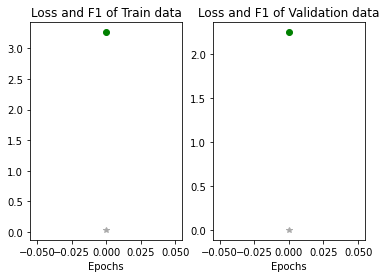

[I 2022-06-01 18:50:51,634] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0001879270715606206, 'weight_decay': 5.188206958282454e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 732
model_name : klue/roberta-base, lr : 0.0027842988049832777, weight_decay : 0.0005171838617732387, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0022936232, Avg Loss : 4.1438, f1 score : 0.1189
Epoch 0 Total Mean Loss : 4.0016
Epoch 0 Total Mean f1 : 0.1262
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4015 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 7.108964204788208초
green is loss, gray is f1


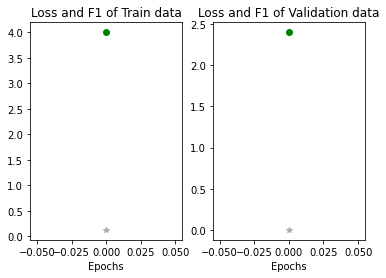

[I 2022-06-01 18:54:06,639] Trial 1 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0027842988049832777, 'weight_decay': 0.0005171838617732387}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0010209518443705513, weight_decay : 0.0005505251243469021, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0009758481, Avg Loss : 5.5950, f1 score : 0.0783
Epoch: 0, Step : 256, LR : 0.0009310941, Avg Loss : 3.7877, f1 score : 0.1051
Epoch: 0, Step : 384, LR : 0.0008863400, Avg Loss : 3.4556, f1 score : 0.0837
Epoch: 0, Step : 512, LR : 0.0008415860, Avg Loss : 3.3212, f1 score : 0.0619
Epoch: 0, Step : 640, LR : 0.0007968319, Avg Loss : 3.4644, f1 score : 0.0802
Epoch 0 Total Mean Loss : 3.8487
Epoch 0 Total Mean f1 : 0.0745
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1639 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.191589117050171초
green is loss, gray is f1


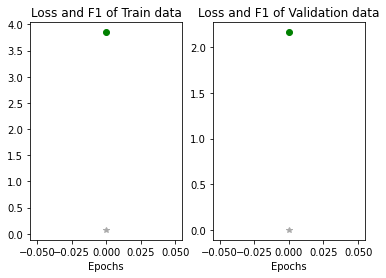

[I 2022-06-01 18:57:28,714] Trial 2 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0010209518443705513, 'weight_decay': 0.0005505251243469021}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 732
model_name : klue/roberta-base, lr : 0.004059361503318601, weight_decay : 4.8061019842105524e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0033439822, Avg Loss : 6.2672, f1 score : 0.1727
Epoch 0 Total Mean Loss : 5.4855
Epoch 0 Total Mean f1 : 0.1612
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2454 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.225990533828735초
green is loss, gray is f1


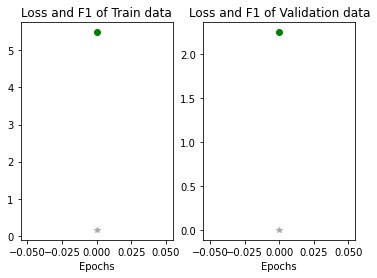

[I 2022-06-01 19:00:46,837] Trial 3 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.004059361503318601, 'weight_decay': 4.8061019842105524e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 732
model_name : klue/roberta-base, lr : 0.00029201743573187185, weight_decay : 4.9943350865686155e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002405553, Avg Loss : 3.4839, f1 score : 0.0437
Epoch 0 Total Mean Loss : 3.4216
Epoch 0 Total Mean f1 : 0.0495
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.6702 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0221],
        [-0.0221,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.07129955291748초
green is loss, gray is f1


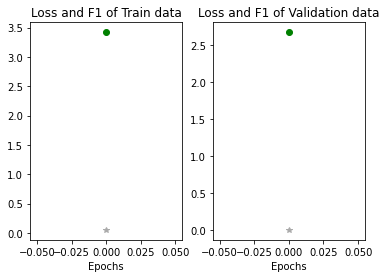

[I 2022-06-01 19:04:03,829] Trial 4 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00029201743573187185, 'weight_decay': 4.9943350865686155e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 732
model_name : klue/roberta-base, lr : 5.11777145335943e-05, weight_decay : 9.476327150936482e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000421587, Avg Loss : 3.2553, f1 score : 0.0189
Epoch 0 Total Mean Loss : 3.2315
Epoch 0 Total Mean f1 : 0.0274
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2155 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0041],
        [0.0041, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.00556993484497초
green is loss, gray is f1


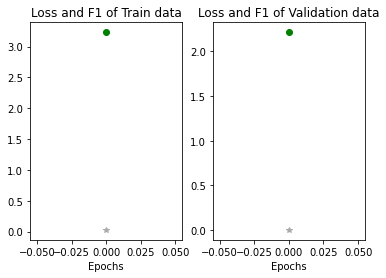

[I 2022-06-01 19:07:21,932] Trial 5 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5.11777145335943e-05, 'weight_decay': 9.476327150936482e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 5.8553272605480005e-05, weight_decay : 0.0007458377924871625, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000533797, Avg Loss : 3.2146, f1 score : 0.0347
Epoch: 0, Step : 256, LR : 0.0000482463, Avg Loss : 3.2133, f1 score : 0.0242
Epoch 0 Total Mean Loss : 3.1923
Epoch 0 Total Mean f1 : 0.0254
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2927 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0301],
        [0.0301, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.950416326522827초
green is loss, gray is f1


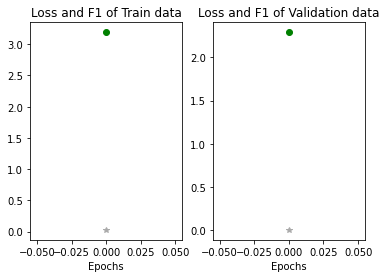

[I 2022-06-01 19:10:39,821] Trial 6 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.8553272605480005e-05, 'weight_decay': 0.0007458377924871625}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 9.006808045587562e-05, weight_decay : 0.0002039006740022102, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000821100, Avg Loss : 3.3010, f1 score : 0.0291
Epoch: 0, Step : 256, LR : 0.0000742136, Avg Loss : 3.3012, f1 score : 0.0414
Epoch 0 Total Mean Loss : 3.2605
Epoch 0 Total Mean f1 : 0.0248
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2173 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0091],
        [0.0091, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.65942645072937초
green is loss, gray is f1


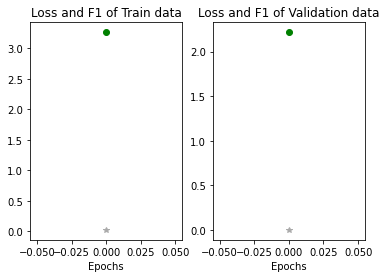

[I 2022-06-01 19:13:58,411] Trial 7 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 9.006808045587562e-05, 'weight_decay': 0.0002039006740022102}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 0.00025471229142534277, weight_decay : 8.991893989737057e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002322069, Avg Loss : 3.4809, f1 score : 0.0829
Epoch: 0, Step : 256, LR : 0.0002098759, Avg Loss : 3.1540, f1 score : 0.0010
Epoch 0 Total Mean Loss : 3.2867
Epoch 0 Total Mean f1 : 0.0320
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2485 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0153],
        [-0.0153,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 11.101269245147705초
green is loss, gray is f1


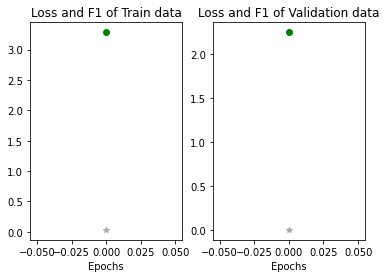

[I 2022-06-01 19:17:17,405] Trial 8 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00025471229142534277, 'weight_decay': 8.991893989737057e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 0.00013855972131655614, weight_decay : 0.0008409688554593648, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001263171, Avg Loss : 3.4417, f1 score : 0.0270
Epoch: 0, Step : 256, LR : 0.0001141694, Avg Loss : 3.2414, f1 score : 0.0482
Epoch 0 Total Mean Loss : 3.2920
Epoch 0 Total Mean f1 : 0.0271
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2794 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0314],
        [-0.0314,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.129756212234497초
green is loss, gray is f1


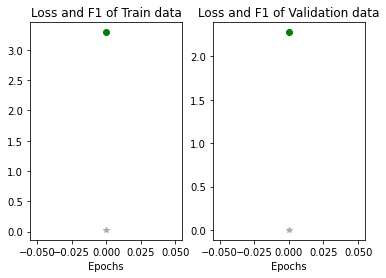

[I 2022-06-01 19:20:35,433] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00013855972131655614, 'weight_decay': 0.0008409688554593648}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.000904586740025679, weight_decay : 0.00019564322400367754, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0008646238, Avg Loss : 3.8110, f1 score : 0.0861
Epoch: 0, Step : 256, LR : 0.0008249707, Avg Loss : 3.2656, f1 score : 0.0138
Epoch: 0, Step : 384, LR : 0.0007853176, Avg Loss : 3.4080, f1 score : 0.0172
Epoch: 0, Step : 512, LR : 0.0007456645, Avg Loss : 3.4288, f1 score : 0.0628
Epoch: 0, Step : 640, LR : 0.0007060114, Avg Loss : 3.4303, f1 score : 0.0744
Epoch 0 Total Mean Loss : 3.4226
Epoch 0 Total Mean f1 : 0.0470
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1858 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.289750099182129초
green is loss, gray is f1


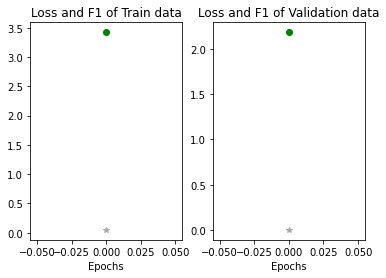

[I 2022-06-01 19:23:57,580] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.000904586740025679, 'weight_decay': 0.00019564322400367754}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.004049936421053379, weight_decay : 0.00036912073392830335, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0038710180, Avg Loss : 4.5488, f1 score : 0.1418
Epoch: 0, Step : 256, LR : 0.0036934865, Avg Loss : 4.2747, f1 score : 0.2060
Epoch: 0, Step : 384, LR : 0.0035159551, Avg Loss : 4.4774, f1 score : 0.2185
Epoch: 0, Step : 512, LR : 0.0033384236, Avg Loss : 3.9747, f1 score : 0.1620
Epoch: 0, Step : 640, LR : 0.0031608922, Avg Loss : 4.1155, f1 score : 0.1833
Epoch 0 Total Mean Loss : 4.3469
Epoch 0 Total Mean f1 : 0.1876
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 5.2870 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0028585339, Avg Loss : 3.8418, f1 score : 0.1179
Epoch: 1, Step : 256, LR : 0.

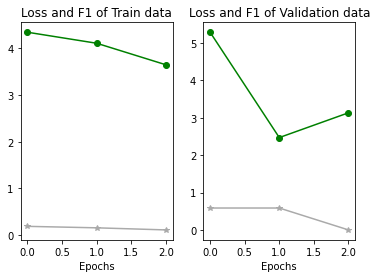

[I 2022-06-01 19:33:50,560] Trial 11 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.004049936421053379, 'weight_decay': 0.00036912073392830335}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0016007195437508321, weight_decay : 0.0002803501441547401, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0015300028, Avg Loss : 6.3054, f1 score : 0.3272
Epoch: 0, Step : 256, LR : 0.0014598343, Avg Loss : 3.5280, f1 score : 0.0559
Epoch: 0, Step : 384, LR : 0.0013896658, Avg Loss : 3.7872, f1 score : 0.1329
Epoch: 0, Step : 512, LR : 0.0013194972, Avg Loss : 3.5797, f1 score : 0.0641
Epoch: 0, Step : 640, LR : 0.0012493287, Avg Loss : 3.5841, f1 score : 0.1091
Epoch 0 Total Mean Loss : 4.1424
Epoch 0 Total Mean f1 : 0.1391
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 3.0806 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.111159086227417초
green is loss, gray is f1


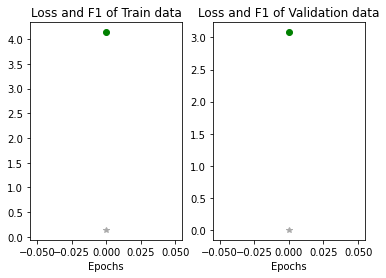

[I 2022-06-01 19:37:12,564] Trial 12 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0016007195437508321, 'weight_decay': 0.0002803501441547401}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0004632123515987336, weight_decay : 0.0002792957318708625, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004427485, Avg Loss : 3.5843, f1 score : 0.1180
Epoch: 0, Step : 256, LR : 0.0004224433, Avg Loss : 3.2051, f1 score : 0.0196
Epoch: 0, Step : 384, LR : 0.0004021381, Avg Loss : 3.2242, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0003818329, Avg Loss : 3.2067, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0003615277, Avg Loss : 3.2632, f1 score : 0.0064
Epoch 0 Total Mean Loss : 3.3014
Epoch 0 Total Mean f1 : 0.0260
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3508 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.73119044303894초
green is loss, gray is f1


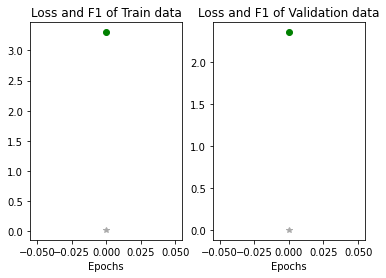

[I 2022-06-01 19:40:34,165] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0004632123515987336, 'weight_decay': 0.0002792957318708625}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.00017963247188846625, weight_decay : 9.971327204859304e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001716967, Avg Loss : 3.4814, f1 score : 0.0564
Epoch: 0, Step : 256, LR : 0.0001638224, Avg Loss : 3.2258, f1 score : 0.0553
Epoch: 0, Step : 384, LR : 0.0001559481, Avg Loss : 3.2569, f1 score : 0.0147
Epoch: 0, Step : 512, LR : 0.0001480738, Avg Loss : 3.2788, f1 score : 0.0286
Epoch: 0, Step : 640, LR : 0.0001401995, Avg Loss : 3.1983, f1 score : 0.0503
Epoch 0 Total Mean Loss : 3.2660
Epoch 0 Total Mean f1 : 0.0361
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1891 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0193],
        [-0.0193,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 15.007411479949951초
green is loss, gray is f1


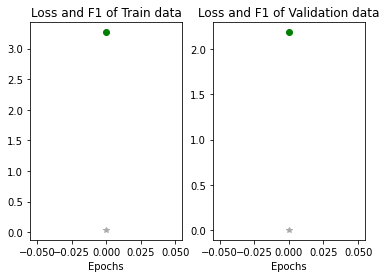

[I 2022-06-01 19:43:57,037] Trial 14 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00017963247188846625, 'weight_decay': 9.971327204859304e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0005136903022145942, weight_decay : 0.0003801236415195203, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004909964, Avg Loss : 3.8183, f1 score : 0.1352
Epoch: 0, Step : 256, LR : 0.0004684785, Avg Loss : 3.2800, f1 score : 0.0264
Epoch: 0, Step : 384, LR : 0.0004459606, Avg Loss : 3.2831, f1 score : 0.0090
Epoch: 0, Step : 512, LR : 0.0004234427, Avg Loss : 3.2620, f1 score : 0.0514
Epoch: 0, Step : 640, LR : 0.0004009247, Avg Loss : 3.1652, f1 score : 0.0188
Epoch 0 Total Mean Loss : 3.3352
Epoch 0 Total Mean f1 : 0.0424
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1650 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.946932554244995초
green is loss, gray is f1


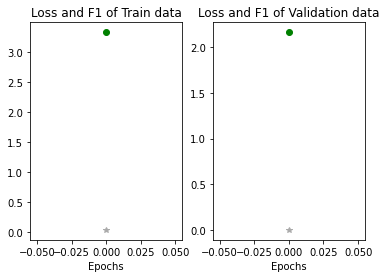

[I 2022-06-01 19:47:18,837] Trial 15 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0005136903022145942, 'weight_decay': 0.0003801236415195203}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0020723325845240456, weight_decay : 0.0001571717301993081, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0019807809, Avg Loss : 4.6822, f1 score : 0.1754
Epoch: 0, Step : 256, LR : 0.0018899389, Avg Loss : 3.9094, f1 score : 0.1736
Epoch: 0, Step : 384, LR : 0.0017990970, Avg Loss : 3.9728, f1 score : 0.1106
Epoch: 0, Step : 512, LR : 0.0017082550, Avg Loss : 3.8863, f1 score : 0.1364
Epoch: 0, Step : 640, LR : 0.0016174130, Avg Loss : 3.6217, f1 score : 0.0574
Epoch 0 Total Mean Loss : 3.9718
Epoch 0 Total Mean f1 : 0.1288
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4242 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.838679313659668초
green is loss, gray is f1


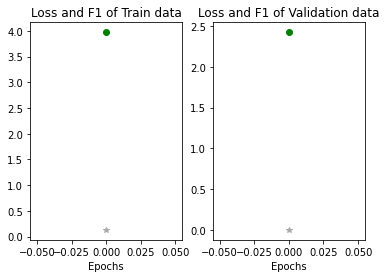

[I 2022-06-01 19:50:40,581] Trial 16 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0020723325845240456, 'weight_decay': 0.0001571717301993081}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.004751023640278792, weight_decay : 0.00013108710814927613, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0045411325, Avg Loss : 7.0173, f1 score : 0.1158
Epoch: 0, Step : 256, LR : 0.0043328685, Avg Loss : 5.7688, f1 score : 0.2339
Epoch: 0, Step : 384, LR : 0.0041246044, Avg Loss : 4.5851, f1 score : 0.2456
Epoch: 0, Step : 512, LR : 0.0039163404, Avg Loss : 4.3337, f1 score : 0.1788
Epoch: 0, Step : 640, LR : 0.0037080763, Avg Loss : 4.5629, f1 score : 0.2051
Epoch 0 Total Mean Loss : 5.1117
Epoch 0 Total Mean f1 : 0.1948
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2421 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.543307542800903초
green is loss, gray is f1


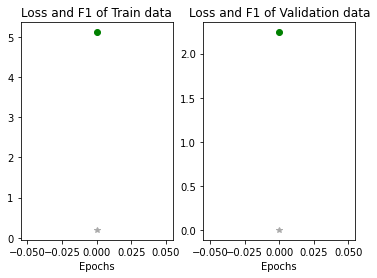

[I 2022-06-01 19:54:03,004] Trial 17 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.004751023640278792, 'weight_decay': 0.00013108710814927613}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0005507607050583447, weight_decay : 6.381211716963217e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005264292, Avg Loss : 3.6653, f1 score : 0.1066
Epoch: 0, Step : 256, LR : 0.0005022862, Avg Loss : 3.3080, f1 score : 0.0140
Epoch: 0, Step : 384, LR : 0.0004781433, Avg Loss : 3.3667, f1 score : 0.0451
Epoch: 0, Step : 512, LR : 0.0004540003, Avg Loss : 3.1382, f1 score : 0.0159
Epoch: 0, Step : 640, LR : 0.0004298574, Avg Loss : 3.4375, f1 score : 0.0627
Epoch 0 Total Mean Loss : 3.3519
Epoch 0 Total Mean f1 : 0.0491
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2769 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.73073148727417초
green is loss, gray is f1


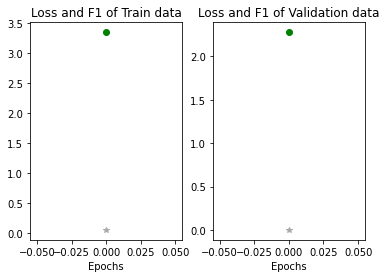

[I 2022-06-01 19:57:24,673] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0005507607050583447, 'weight_decay': 6.381211716963217e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 9.52480920110636e-05, weight_decay : 0.0003382204689962209, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000910402, Avg Loss : 3.4239, f1 score : 0.0423
Epoch: 0, Step : 256, LR : 0.0000868650, Avg Loss : 3.2528, f1 score : 0.0093
Epoch: 0, Step : 384, LR : 0.0000826897, Avg Loss : 3.1783, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000785144, Avg Loss : 3.1666, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000743392, Avg Loss : 3.1003, f1 score : 0.0100
Epoch 0 Total Mean Loss : 3.2164
Epoch 0 Total Mean f1 : 0.0109
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1645 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0493],
        [0.0493, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.28815221786499초
green is loss, gray is f1


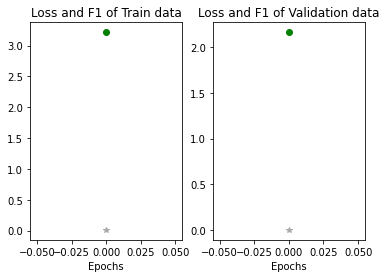

[I 2022-06-01 20:00:46,843] Trial 19 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 9.52480920110636e-05, 'weight_decay': 0.0003382204689962209}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0012093614678784646, weight_decay : 4.056393013297178e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0011559342, Avg Loss : 5.9567, f1 score : 0.2438
Epoch: 0, Step : 256, LR : 0.0011029211, Avg Loss : 3.6161, f1 score : 0.0954
Epoch: 0, Step : 384, LR : 0.0010499080, Avg Loss : 3.4594, f1 score : 0.0979
Epoch: 0, Step : 512, LR : 0.0009968949, Avg Loss : 3.4554, f1 score : 0.0303
Epoch: 0, Step : 640, LR : 0.0009438818, Avg Loss : 3.5463, f1 score : 0.0829
Epoch 0 Total Mean Loss : 3.9087
Epoch 0 Total Mean f1 : 0.0998
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2049 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.915832042694092초
green is loss, gray is f1


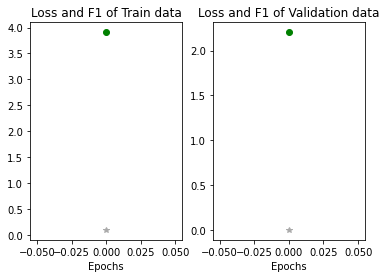

[I 2022-06-01 20:04:08,652] Trial 20 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0012093614678784646, 'weight_decay': 4.056393013297178e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0005334477815087158, weight_decay : 6.105261982076155e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005098811, Avg Loss : 3.7678, f1 score : 0.0920
Epoch: 0, Step : 256, LR : 0.0004864971, Avg Loss : 3.2215, f1 score : 0.0131
Epoch: 0, Step : 384, LR : 0.0004631131, Avg Loss : 3.2914, f1 score : 0.0147
Epoch: 0, Step : 512, LR : 0.0004397290, Avg Loss : 3.3570, f1 score : 0.0413
Epoch: 0, Step : 640, LR : 0.0004163450, Avg Loss : 3.2166, f1 score : 0.0359
Epoch 0 Total Mean Loss : 3.3468
Epoch 0 Total Mean f1 : 0.0347
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2418 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0377],
        [0.0377, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.233896017074585초
green is loss, gray is f1


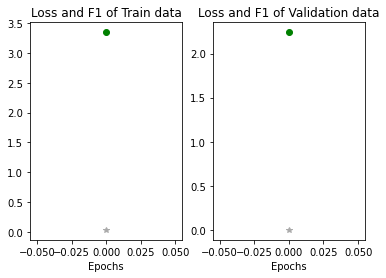

[I 2022-06-01 20:07:30,794] Trial 21 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0005334477815087158, 'weight_decay': 6.105261982076155e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.00012103182818841524, weight_decay : 0.0003142164256637671, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001156849, Avg Loss : 3.4467, f1 score : 0.0553
Epoch: 0, Step : 256, LR : 0.0001103794, Avg Loss : 3.1820, f1 score : 0.0277
Epoch: 0, Step : 384, LR : 0.0001050739, Avg Loss : 3.2922, f1 score : 0.0166
Epoch: 0, Step : 512, LR : 0.0000997684, Avg Loss : 3.2066, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000944629, Avg Loss : 3.1535, f1 score : 0.0350
Epoch 0 Total Mean Loss : 3.2328
Epoch 0 Total Mean f1 : 0.0237
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1988 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0670],
        [0.0670, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 15.900519371032715초
green is loss, gray is f1


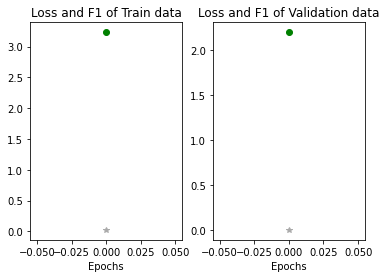

[I 2022-06-01 20:10:54,636] Trial 22 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00012103182818841524, 'weight_decay': 0.0003142164256637671}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.001118435173117378, weight_decay : 0.00045728472809156417, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0010690249, Avg Loss : 5.1100, f1 score : 0.1859
Epoch: 0, Step : 256, LR : 0.0010199976, Avg Loss : 3.3403, f1 score : 0.0408
Epoch: 0, Step : 384, LR : 0.0009709703, Avg Loss : 3.6175, f1 score : 0.0761
Epoch: 0, Step : 512, LR : 0.0009219430, Avg Loss : 3.5203, f1 score : 0.0677
Epoch: 0, Step : 640, LR : 0.0008729157, Avg Loss : 3.3636, f1 score : 0.0700
Epoch 0 Total Mean Loss : 3.7264
Epoch 0 Total Mean f1 : 0.0841
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3538 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 15.169874429702759초
green is loss, gray is f1


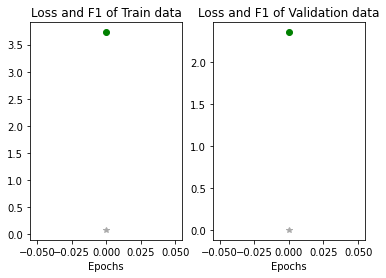

[I 2022-06-01 20:14:17,714] Trial 23 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.001118435173117378, 'weight_decay': 0.00045728472809156417}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.002612161030817626, weight_decay : 6.0188780318719275e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0024967608, Avg Loss : 4.9853, f1 score : 0.2270
Epoch: 0, Step : 256, LR : 0.0023822551, Avg Loss : 3.9437, f1 score : 0.1435
Epoch: 0, Step : 384, LR : 0.0022677494, Avg Loss : 3.8003, f1 score : 0.0973
Epoch: 0, Step : 512, LR : 0.0021532437, Avg Loss : 3.6677, f1 score : 0.1282
Epoch: 0, Step : 640, LR : 0.0020387380, Avg Loss : 4.2253, f1 score : 0.2157
Epoch 0 Total Mean Loss : 4.1179
Epoch 0 Total Mean f1 : 0.1598
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.8644 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0018437205, Avg Loss : 4.1741, f1 score : 0.2188
Epoch: 1, Step : 256, LR : 0.

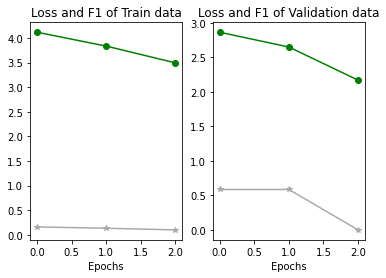

[I 2022-06-01 20:24:09,565] Trial 24 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.002612161030817626, 'weight_decay': 6.0188780318719275e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0029154988930296497, weight_decay : 0.0002408099026849522, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0027866977, Avg Loss : 4.8084, f1 score : 0.1713
Epoch: 0, Step : 256, LR : 0.0026588951, Avg Loss : 4.1844, f1 score : 0.1672
Epoch: 0, Step : 384, LR : 0.0025310924, Avg Loss : 3.7845, f1 score : 0.1208
Epoch: 0, Step : 512, LR : 0.0024032897, Avg Loss : 3.6882, f1 score : 0.0994
Epoch: 0, Step : 640, LR : 0.0022754870, Avg Loss : 3.9797, f1 score : 0.1619
Epoch 0 Total Mean Loss : 4.0482
Epoch 0 Total Mean f1 : 0.1457
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 3.1636 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.161690473556519초
green is loss, gray is f1


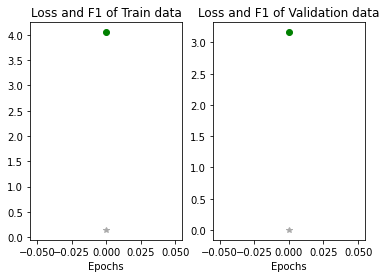

[I 2022-06-01 20:27:31,631] Trial 25 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0029154988930296497, 'weight_decay': 0.0002408099026849522}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0031727291622200803, weight_decay : 8.101692680147981e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0030325641, Avg Loss : 5.3260, f1 score : 0.2303
Epoch: 0, Step : 256, LR : 0.0028934855, Avg Loss : 4.4652, f1 score : 0.1832
Epoch: 0, Step : 384, LR : 0.0027544070, Avg Loss : 4.3255, f1 score : 0.2006
Epoch: 0, Step : 512, LR : 0.0026153285, Avg Loss : 4.1207, f1 score : 0.1815
Epoch: 0, Step : 640, LR : 0.0024762499, Avg Loss : 4.4736, f1 score : 0.1813
Epoch 0 Total Mean Loss : 4.4788
Epoch 0 Total Mean f1 : 0.1909
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.5013 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0022393818, Avg Loss : 4.9110, f1 score : 0.2126
Epoch: 1, Step : 256, LR : 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Total Mean Loss : 4.0295
Epoch 1 Total Mean f1 : 0.1443
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 4.5591 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 1 Valid Finish*****

Train Finished
time : 6.0분 30.091983556747437초
green is loss, gray is f1


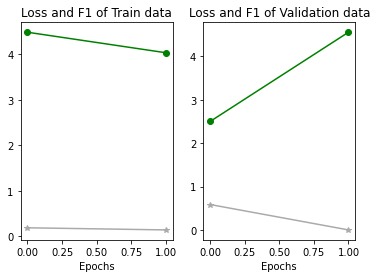

[I 2022-06-01 20:34:09,611] Trial 26 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0031727291622200803, 'weight_decay': 8.101692680147981e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0029642816705764165, weight_decay : 6.930535810753779e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0028333254, Avg Loss : 4.7286, f1 score : 0.1958
Epoch: 0, Step : 256, LR : 0.0027033843, Avg Loss : 4.2245, f1 score : 0.2057
Epoch: 0, Step : 384, LR : 0.0025734432, Avg Loss : 3.7417, f1 score : 0.1331
Epoch: 0, Step : 512, LR : 0.0024435020, Avg Loss : 3.8497, f1 score : 0.0858
Epoch: 0, Step : 640, LR : 0.0023135609, Avg Loss : 3.8333, f1 score : 0.1551
Epoch 0 Total Mean Loss : 4.0464
Epoch 0 Total Mean f1 : 0.1559
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2258 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.172313690185547초
green is loss, gray is f1


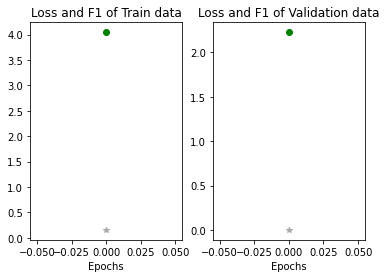

[I 2022-06-01 20:37:31,705] Trial 27 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0029642816705764165, 'weight_decay': 6.930535810753779e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 1460
model_name : klue/roberta-base, lr : 0.0018802362880514355, weight_decay : 0.00012369377246340048, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0017141058, Avg Loss : 5.1738, f1 score : 0.2011
Epoch: 0, Step : 256, LR : 0.0015492632, Avg Loss : 4.0328, f1 score : 0.1398
Epoch 0 Total Mean Loss : 4.2827
Epoch 0 Total Mean f1 : 0.1449
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3358 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.632064819335938초
green is loss, gray is f1


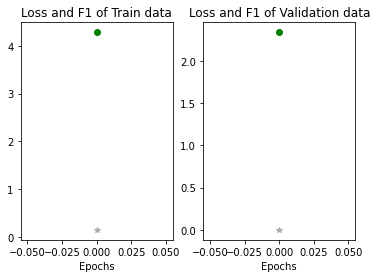

[I 2022-06-01 20:40:50,205] Trial 28 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0018802362880514355, 'weight_decay': 0.00012369377246340048}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 64
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 732
model_name : klue/roberta-base, lr : 0.0034594192839795435, weight_decay : 7.296978721919274e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0028497675, Avg Loss : 4.4539, f1 score : 0.1441
Epoch 0 Total Mean Loss : 4.1924
Epoch 0 Total Mean f1 : 0.1297
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.7498 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.1982581615448초
green is loss, gray is f1


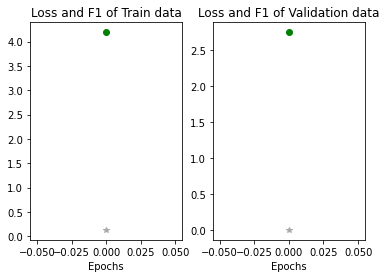

[I 2022-06-01 20:44:07,302] Trial 29 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0034594192839795435, 'weight_decay': 7.296978721919274e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.0024706931471786546, weight_decay : 0.00014056251733550123, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0023615427, Avg Loss : 5.0229, f1 score : 0.2279
Epoch: 0, Step : 256, LR : 0.0022532383, Avg Loss : 4.2257, f1 score : 0.1773
Epoch: 0, Step : 384, LR : 0.0021449339, Avg Loss : 3.8220, f1 score : 0.1446
Epoch: 0, Step : 512, LR : 0.0020366296, Avg Loss : 4.4693, f1 score : 0.2065
Epoch: 0, Step : 640, LR : 0.0019283252, Avg Loss : 4.1032, f1 score : 0.1855
Epoch 0 Total Mean Loss : 4.3221
Epoch 0 Total Mean f1 : 0.1896
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3377 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.503501653671265초
green is loss, gray is f1


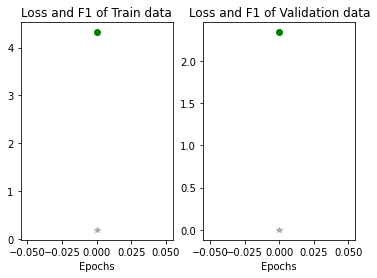

[I 2022-06-01 20:47:29,632] Trial 30 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0024706931471786546, 'weight_decay': 0.00014056251733550123}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at klue/roberta-base were not used when initializing BertForNextSentencePrediction: ['roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.6.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.6.attention.self.query.bias', 'roberta.encoder.layer.4.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.se

Total train steps with 4 epochs: 2920
model_name : klue/roberta-base, lr : 0.004369251757767481, weight_decay : 4.121553829320163e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0041762266, Avg Loss : 5.4715, f1 score : 0.1793
Epoch: 0, Step : 256, LR : 0.0039846978, Avg Loss : 4.4935, f1 score : 0.1698
Epoch: 0, Step : 384, LR : 0.0037931689, Avg Loss : 4.7040, f1 score : 0.2196
Epoch: 0, Step : 512, LR : 0.0036016401, Avg Loss : 4.4067, f1 score : 0.1808
Epoch: 0, Step : 640, LR : 0.0034101112, Avg Loss : 3.9039, f1 score : 0.1722
Epoch 0 Total Mean Loss : 4.5462
Epoch 0 Total Mean f1 : 0.1789
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 3.7827 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 14.141983032226562초
green is loss, gray is f1


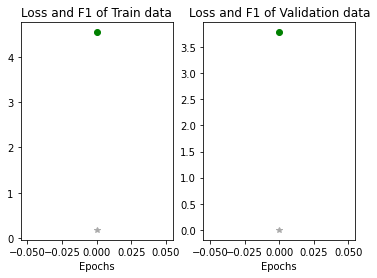

[I 2022-06-01 20:50:51,702] Trial 31 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.004369251757767481, 'weight_decay': 4.121553829320163e-05}. Best is trial 11 with value: 0.585747622409982.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [40]:
print('klue/roberta-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

### snunlp/KR-Medium

train_batch_size, validation_batch_size, lr, weight_decay, epochs -> f1

1. 64, 32, 1e-04, 1e-04, 2 -> **0.7718**
2. 32, 32, 6e-05, 3e-04, 3 -> 0.7284
5. 32, 32, 1e-04, 4e-05, 3 -> 0.7583
6. 32, 32, 1e-04, 6e-04, 4 -> 0.7386
7. 16, 32, 1e-04, 9e-04, 3 -> 0.7086
11. 64, 32, 6e-05, 1e-04, 3 -> 0.7332
12. 64, 32, 1e-04, 9.7e-05, 3 -> 0.7472
13. 16, 32, 9e-05, 7.7e-05, 4 -> 0.7386
14. 32, 32, 1e-04, 1e-04, 4 -> 0.7463
17. 64, 32, 2e-4, 6e-05, 4 -> 0.7540
19. 16, 32, 1e-04, 4e095, 4 -> 0.7399
20. 64, 32, 5e-05, 1e-04, 3 -> 0.7319
21. 64, 32, 2e-04, 6e-05, 2 -> 0.7224
22. 64, 32, 2e-04, 8e-05, 3 -> 0.7413
23. 64, 32, 1e-04, 5e-05, 2 -> 0.7588
24. 64, 32, 1e-04, 5e-05, 4 -> **0.7653**
25. 64, 32, 8e-05, 9.8e-05, 2 -> 0.7602
26. 64. 32. 7e-05, 9e-05, 3 -> 0.7417
27. 64, 32, 8e-05, 1e-04, 3 -> 0.7424
28. 64, 32, 4e-04, 2e-04, 1 -> 0.7228
29. 64, 32, 2e-04, 7e-05, 2 -> 0.7363
30. 64, 32, 7e-05, 1e-04, 3 -> 0.7483
31. 64, 32, 1e-04, 5e-05, 4 -> **0.7798**

[I 2022-06-01 22:56:04,377] A new study created in memory with name: hyper-parameter-search


snunlp/KR-Medium


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0035446600973081345, weight_decay : 6.80055727160712e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0032314675, Avg Loss : 4.1742, f1 score : 0.1639
Epoch: 0, Step : 256, LR : 0.0029207028, Avg Loss : 4.1496, f1 score : 0.1766
Epoch 0 Total Mean Loss : 4.2033
Epoch 0 Total Mean f1 : 0.1738
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1957 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 43.15835666656494초
green is loss, gray is f1


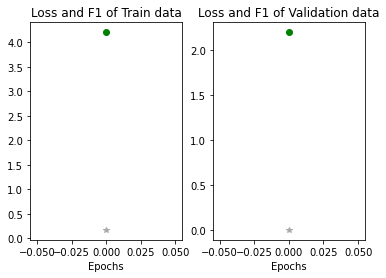

[I 2022-06-01 22:58:57,184] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0035446600973081345, 'weight_decay': 6.80055727160712e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00013745913653971363, weight_decay : 0.00012930199937935666, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001132348, Avg Loss : 2.1054, f1 score : 0.5033
Epoch 0 Total Mean Loss : 1.6535
Epoch 0 Total Mean f1 : 0.6199
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0240 Valid Acc : 0.7340 Valid f1 : 0.7374
pearson 상관 계수 ; tensor([[1.0000, 0.7673],
        [0.7673, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:1.0240_f1:0.7374.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000788700, Avg Loss : 0.3947, f1 score : 0.9130
Epoch 1 Total Mean Loss : 0.3636
Epoch 1 Total Mean f1 : 0.9190
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8918 Valid Acc : 0.7542 Valid f1 : 0.7718
pearson 상관 계수 ; tensor([[1.000

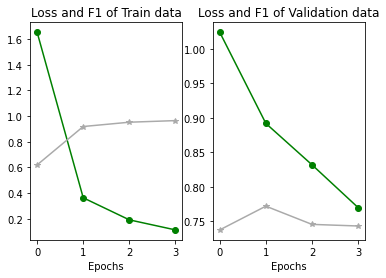

[I 2022-06-01 23:10:14,243] Trial 1 finished with value: 0.7718284836472763 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00013745913653971363, 'weight_decay': 0.00012930199937935666}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 6.310591620615696e-05, weight_decay : 0.0003049254133942781, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000575301, Avg Loss : 0.6615, f1 score : 0.8921
Epoch: 0, Step : 256, LR : 0.0000519975, Avg Loss : 0.3726, f1 score : 0.9146
Epoch 0 Total Mean Loss : 0.4581
Epoch 0 Total Mean f1 : 0.9107
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8858 Valid Acc : 0.7266 Valid f1 : 0.7177
pearson 상관 계수 ; tensor([[1.0000, 0.7959],
        [0.7959, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000417536, Avg Loss : 0.1954, f1 score : 0.9480
Epoch: 1, Step : 256, LR : 0.0000362211, Avg Loss : 0.1917, f1 score : 0.9476
Epoch 1 Total Mean Loss : 0.1875
Epoch 1 Total Mean f1 : 0.9500
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7939 Valid Acc : 0.7285 

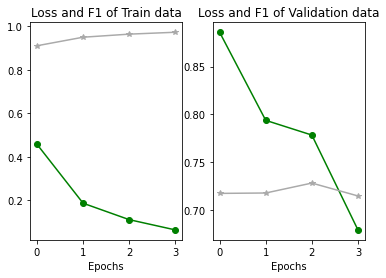

[I 2022-06-01 23:21:27,434] Trial 2 finished with value: 0.7284392380359539 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 6.310591620615696e-05, 'weight_decay': 0.0003049254133942781}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 0.0034235467032770906, weight_decay : 4.974676528640889e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0032723010, Avg Loss : 4.2713, f1 score : 0.1676
Epoch: 0, Step : 256, LR : 0.0031222277, Avg Loss : 4.2618, f1 score : 0.1156
Epoch: 0, Step : 384, LR : 0.0029721544, Avg Loss : 4.0599, f1 score : 0.1744
Epoch: 0, Step : 512, LR : 0.0028220811, Avg Loss : 4.5893, f1 score : 0.1734
Epoch: 0, Step : 640, LR : 0.0026720079, Avg Loss : 4.6800, f1 score : 0.1870
Epoch 0 Total Mean Loss : 4.2747
Epoch 0 Total Mean f1 : 0.1532
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2115 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 48.68531656265259초
green is loss, gray is f1


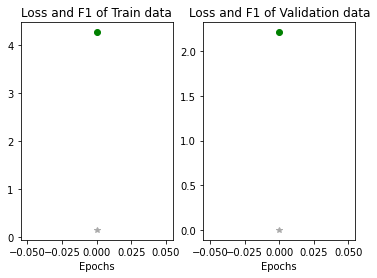

[I 2022-06-01 23:24:25,804] Trial 3 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0034235467032770906, 'weight_decay': 4.974676528640889e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0016645853006722893, weight_decay : 0.0003614882745632192, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0013712363, Avg Loss : 3.8758, f1 score : 0.1028
Epoch 0 Total Mean Loss : 3.7223
Epoch 0 Total Mean f1 : 0.1118
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1632 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 43.93367147445679초
green is loss, gray is f1


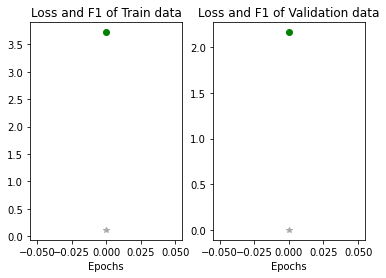

[I 2022-06-01 23:27:19,385] Trial 4 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0016645853006722893, 'weight_decay': 0.0003614882745632192}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0001590409727061356, weight_decay : 4.673453914441065e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001449887, Avg Loss : 0.9267, f1 score : 0.8363
Epoch: 0, Step : 256, LR : 0.0001310454, Avg Loss : 0.4409, f1 score : 0.9056
Epoch 0 Total Mean Loss : 0.5928
Epoch 0 Total Mean f1 : 0.8861
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0195 Valid Acc : 0.7156 Valid f1 : 0.7265
pearson 상관 계수 ; tensor([[1.0000, 0.7562],
        [0.7562, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001052285, Avg Loss : 0.2614, f1 score : 0.9344
Epoch: 1, Step : 256, LR : 0.0000912852, Avg Loss : 0.2576, f1 score : 0.9410
Epoch 1 Total Mean Loss : 0.2477
Epoch 1 Total Mean f1 : 0.9405
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7539 Valid Acc : 0.7524 

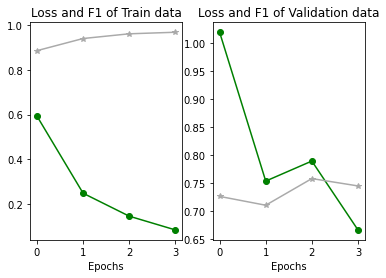

[I 2022-06-01 23:38:30,755] Trial 5 finished with value: 0.7583376063852055 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0001590409727061356, 'weight_decay': 4.673453914441065e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.00017771687063984493, weight_decay : 0.0006150603955195586, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001620145, Avg Loss : 0.9249, f1 score : 0.8349
Epoch: 0, Step : 256, LR : 0.0001464338, Avg Loss : 0.4892, f1 score : 0.8914
Epoch 0 Total Mean Loss : 0.6356
Epoch 0 Total Mean f1 : 0.8786
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.5502 Valid Acc : 0.6605 Valid f1 : 0.7012
pearson 상관 계수 ; tensor([[1.0000, 0.6911],
        [0.6911, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001175853, Avg Loss : 0.3335, f1 score : 0.9232
Epoch: 1, Step : 256, LR : 0.0001020046, Avg Loss : 0.3296, f1 score : 0.9328
Epoch 1 Total Mean Loss : 0.3204
Epoch 1 Total Mean f1 : 0.9289
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0478 Valid Acc : 0.7156

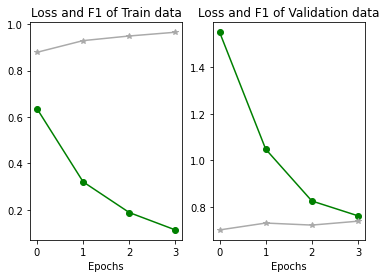

[I 2022-06-01 23:49:41,230] Trial 6 finished with value: 0.738645686037735 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00017771687063984493, 'weight_decay': 0.0006150603955195586}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 0.00017602708358109963, weight_decay : 0.0009628632175295247, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001682505, Avg Loss : 1.1600, f1 score : 0.7914
Epoch: 0, Step : 256, LR : 0.0001605343, Avg Loss : 0.7241, f1 score : 0.8631
Epoch: 0, Step : 384, LR : 0.0001528180, Avg Loss : 0.6191, f1 score : 0.9003
Epoch: 0, Step : 512, LR : 0.0001451018, Avg Loss : 0.6157, f1 score : 0.8643
Epoch: 0, Step : 640, LR : 0.0001373855, Avg Loss : 0.5371, f1 score : 0.8886
Epoch 0 Total Mean Loss : 0.7137
Epoch 0 Total Mean f1 : 0.8629
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.4278 Valid Acc : 0.6807 Valid f1 : 0.6803
pearson 상관 계수 ; tensor([[1.0000, 0.6918],
        [0.6918, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001242438, Avg Loss : 0.4892, f1 score : 0.8975
Epoch: 1, Step :

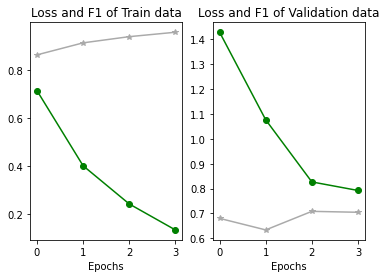

[I 2022-06-02 00:01:12,773] Trial 7 finished with value: 0.7086196017013934 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00017602708358109963, 'weight_decay': 0.0009628632175295247}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0003987420839400137, weight_decay : 4.371048818962608e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0003635108, Avg Loss : 3.3746, f1 score : 0.0193
Epoch: 0, Step : 256, LR : 0.0003285526, Avg Loss : 3.1383, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.2093
Epoch 0 Total Mean f1 : 0.0068
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1649 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0536],
        [0.0536, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 42.47465682029724초
green is loss, gray is f1


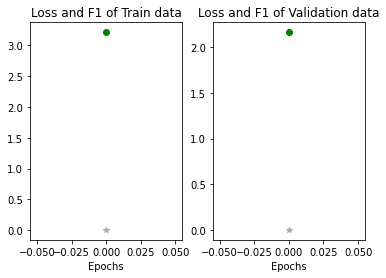

[I 2022-06-02 00:04:04,905] Trial 8 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0003987420839400137, 'weight_decay': 4.371048818962608e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0023215721091742266, weight_decay : 0.00044690385882791483, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0021164469, Avg Loss : 4.1916, f1 score : 0.1285
Epoch: 0, Step : 256, LR : 0.0019129118, Avg Loss : 3.6444, f1 score : 0.1471
Epoch 0 Total Mean Loss : 3.9033
Epoch 0 Total Mean f1 : 0.1318
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3908 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 43.55595088005066초
green is loss, gray is f1


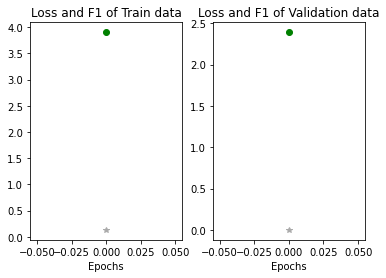

[I 2022-06-02 00:06:58,112] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0023215721091742266, 'weight_decay': 0.00044690385882791483}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0008356421884314532, weight_decay : 0.0001277605116624145, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0006883774, Avg Loss : 3.4074, f1 score : 0.0367
Epoch 0 Total Mean Loss : 3.3298
Epoch 0 Total Mean f1 : 0.0259
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3563 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 44.389917612075806초
green is loss, gray is f1


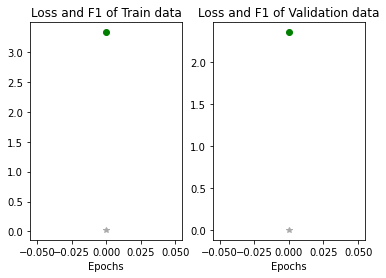

[I 2022-06-02 00:09:52,115] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0008356421884314532, 'weight_decay': 0.0001277605116624145}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 5.966807454523438e-05, weight_decay : 0.00012881171299642844, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000491528, Avg Loss : 0.5595, f1 score : 0.8955
Epoch 0 Total Mean Loss : 0.4885
Epoch 0 Total Mean f1 : 0.9053
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9495 Valid Acc : 0.7174 Valid f1 : 0.7326
pearson 상관 계수 ; tensor([[1.0000, 0.7947],
        [0.7947, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000342358, Avg Loss : 0.1906, f1 score : 0.9504
Epoch 1 Total Mean Loss : 0.1858
Epoch 1 Total Mean f1 : 0.9512
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8615 Valid Acc : 0.7211 Valid f1 : 0.7310
pearson 상관 계수 ; tensor([[1.0000, 0.8153],
        [0.8153, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

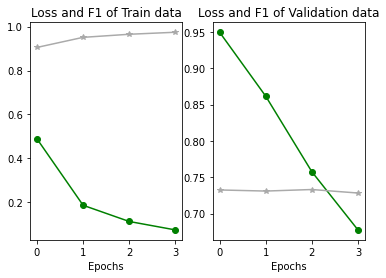

[I 2022-06-02 00:21:01,070] Trial 11 finished with value: 0.7331655966414213 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5.966807454523438e-05, 'weight_decay': 0.00012881171299642844}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00017026794684870544, weight_decay : 9.70797765168683e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001402617, Avg Loss : 0.6544, f1 score : 0.8803
Epoch 0 Total Mean Loss : 0.5715
Epoch 0 Total Mean f1 : 0.8921
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.3885 Valid Acc : 0.6899 Valid f1 : 0.7331
pearson 상관 계수 ; tensor([[1.0000, 0.7502],
        [0.7502, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000976947, Avg Loss : 0.2531, f1 score : 0.9383
Epoch 1 Total Mean Loss : 0.2460
Epoch 1 Total Mean f1 : 0.9395
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8052 Valid Acc : 0.7395 Valid f1 : 0.7127
pearson 상관 계수 ; tensor([[1.0000, 0.7968],
        [0.7968, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

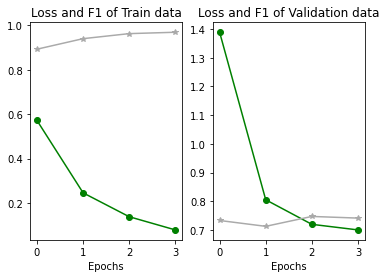

[I 2022-06-02 00:32:14,769] Trial 12 finished with value: 0.7471814289305659 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00017026794684870544, 'weight_decay': 9.70797765168683e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0003376411423590586, weight_decay : 0.0002002532354118441, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002781388, Avg Loss : 3.3215, f1 score : 0.0221
Epoch 0 Total Mean Loss : 3.2378
Epoch 0 Total Mean f1 : 0.0156
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1643 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0046],
        [-0.0046,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 44.67133188247681초
green is loss, gray is f1


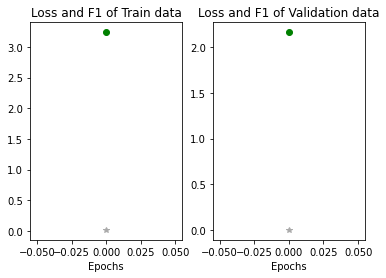

[I 2022-06-02 00:35:09,093] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0003376411423590586, 'weight_decay': 0.0002002532354118441}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 9.27366999767169e-05, weight_decay : 7.767917727452706e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000886398, Avg Loss : 0.8681, f1 score : 0.8505
Epoch: 0, Step : 256, LR : 0.0000845746, Avg Loss : 0.5386, f1 score : 0.8798
Epoch: 0, Step : 384, LR : 0.0000805094, Avg Loss : 0.4827, f1 score : 0.8966
Epoch: 0, Step : 512, LR : 0.0000764443, Avg Loss : 0.4490, f1 score : 0.9128
Epoch: 0, Step : 640, LR : 0.0000723791, Avg Loss : 0.3811, f1 score : 0.9170
Epoch 0 Total Mean Loss : 0.5296
Epoch 0 Total Mean f1 : 0.8933
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9022 Valid Acc : 0.7358 Valid f1 : 0.7298
pearson 상관 계수 ; tensor([[1.0000, 0.7807],
        [0.7807, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000654556, Avg Loss : 0.2707, f1 score : 0.9370
Epoch: 1, Step : 2

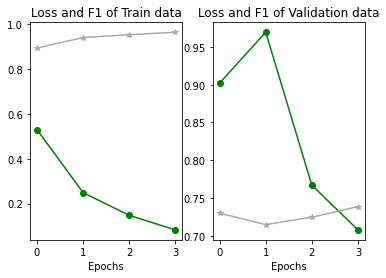

[I 2022-06-02 00:46:39,168] Trial 14 finished with value: 0.73859933070888 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 9.27366999767169e-05, 'weight_decay': 7.767917727452706e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0007481694012163731, weight_decay : 0.00019780882315593534, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0006163199, Avg Loss : 3.3722, f1 score : 0.0347
Epoch 0 Total Mean Loss : 3.2921
Epoch 0 Total Mean f1 : 0.0244
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4664 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0040],
        [0.0040, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 44.086620569229126초
green is loss, gray is f1


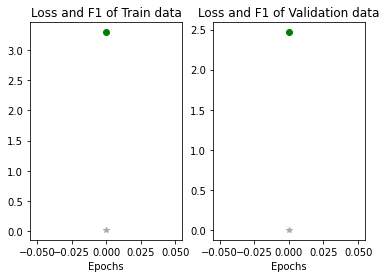

[I 2022-06-02 00:49:32,961] Trial 15 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0007481694012163731, 'weight_decay': 0.00019780882315593534}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0001123211574197888, weight_decay : 0.00018507779727427426, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001023969, Avg Loss : 1.0379, f1 score : 0.8007
Epoch: 0, Step : 256, LR : 0.0000925496, Avg Loss : 0.3869, f1 score : 0.9211
Epoch 0 Total Mean Loss : 0.6053
Epoch 0 Total Mean f1 : 0.8798
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8536 Valid Acc : 0.7413 Valid f1 : 0.6785
pearson 상관 계수 ; tensor([[1.0000, 0.7828],
        [0.7828, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000743166, Avg Loss : 0.2321, f1 score : 0.9416
Epoch: 1, Step : 256, LR : 0.0000644693, Avg Loss : 0.2283, f1 score : 0.9439
Epoch 1 Total Mean Loss : 0.2263
Epoch 1 Total Mean f1 : 0.9443
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8967 Valid Acc : 0.7193

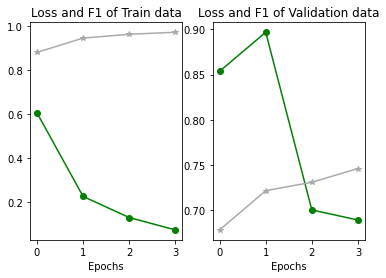

[I 2022-06-02 01:00:44,067] Trial 16 finished with value: 0.7462714970023493 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0001123211574197888, 'weight_decay': 0.00018507779727427426}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00026496465085808267, weight_decay : 6.162271778546087e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002182701, Avg Loss : 0.7082, f1 score : 0.8685
Epoch 0 Total Mean Loss : 0.6453
Epoch 0 Total Mean f1 : 0.8795
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8823 Valid Acc : 0.7513 Valid f1 : 0.7285
pearson 상관 계수 ; tensor([[1.0000, 0.7814],
        [0.7814, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001520289, Avg Loss : 0.2931, f1 score : 0.9315
Epoch 1 Total Mean Loss : 0.2783
Epoch 1 Total Mean f1 : 0.9339
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8624 Valid Acc : 0.7442 Valid f1 : 0.7429
pearson 상관 계수 ; tensor([[1.0000, 0.7921],
        [0.7921, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

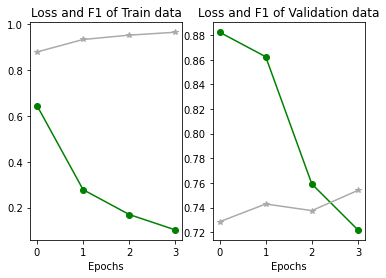

[I 2022-06-02 01:11:54,843] Trial 17 finished with value: 0.7539609970657538 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00026496465085808267, 'weight_decay': 6.162271778546087e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0006197089848272739, weight_decay : 0.00010362622169345058, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005649539, Avg Loss : 3.3041, f1 score : 0.0320
Epoch: 0, Step : 256, LR : 0.0005106232, Avg Loss : 3.2016, f1 score : 0.0210
Epoch 0 Total Mean Loss : 3.2405
Epoch 0 Total Mean f1 : 0.0187
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2538 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 2.0분 44.65816831588745초
green is loss, gray is f1


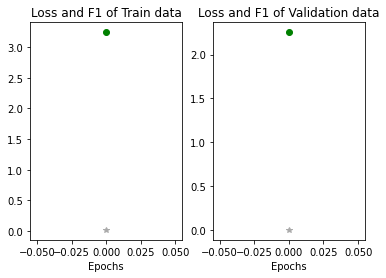

[I 2022-06-02 01:14:49,163] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0006197089848272739, 'weight_decay': 0.00010362622169345058}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 0.00010467514212278564, weight_decay : 4.108904067821048e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001000508, Avg Loss : 0.8179, f1 score : 0.8545
Epoch: 0, Step : 256, LR : 0.0000954623, Avg Loss : 0.4574, f1 score : 0.9031
Epoch: 0, Step : 384, LR : 0.0000908738, Avg Loss : 0.4523, f1 score : 0.8902
Epoch: 0, Step : 512, LR : 0.0000862853, Avg Loss : 0.4394, f1 score : 0.9071
Epoch: 0, Step : 640, LR : 0.0000816968, Avg Loss : 0.4094, f1 score : 0.9065
Epoch 0 Total Mean Loss : 0.4998
Epoch 0 Total Mean f1 : 0.8953
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.5131 Valid Acc : 0.6384 Valid f1 : 0.6886
pearson 상관 계수 ; tensor([[1.0000, 0.7201],
        [0.7201, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000738820, Avg Loss : 0.2449, f1 score : 0.9385
Epoch: 1, Step :

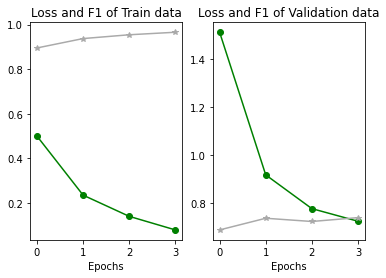

[I 2022-06-02 01:26:20,756] Trial 19 finished with value: 0.7399430445887294 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00010467514212278564, 'weight_decay': 4.108904067821048e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 5.029356865838773e-05, weight_decay : 0.00014277802894312175, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000414304, Avg Loss : 0.5967, f1 score : 0.8950
Epoch 0 Total Mean Loss : 0.5132
Epoch 0 Total Mean f1 : 0.9054
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8738 Valid Acc : 0.7046 Valid f1 : 0.6993
pearson 상관 계수 ; tensor([[1.0000, 0.7871],
        [0.7871, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000288570, Avg Loss : 0.1892, f1 score : 0.9505
Epoch 1 Total Mean Loss : 0.1833
Epoch 1 Total Mean f1 : 0.9528
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8753 Valid Acc : 0.7082 Valid f1 : 0.7164
pearson 상관 계수 ; tensor([[1.0000, 0.8004],
        [0.8004, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

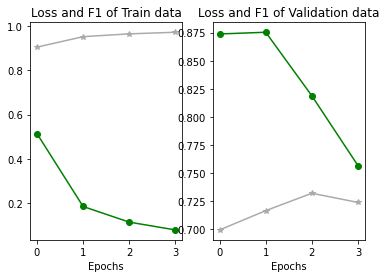

[I 2022-06-02 01:37:33,335] Trial 20 finished with value: 0.7319486748907295 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5.029356865838773e-05, 'weight_decay': 0.00014277802894312175}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00029317478141001346, weight_decay : 6.041632487554555e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002415087, Avg Loss : 0.8479, f1 score : 0.8413
Epoch 0 Total Mean Loss : 0.7360
Epoch 0 Total Mean f1 : 0.8615
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0357 Valid Acc : 0.7148 Valid f1 : 0.6487
pearson 상관 계수 ; tensor([[1.0000, 0.7563],
        [0.7563, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001682150, Avg Loss : 0.3399, f1 score : 0.9267
Epoch 1 Total Mean Loss : 0.3301
Epoch 1 Total Mean f1 : 0.9287
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.2195 Valid Acc : 0.6917 Valid f1 : 0.7224
pearson 상관 계수 ; tensor([[1.0000, 0.7491],
        [0.7491, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

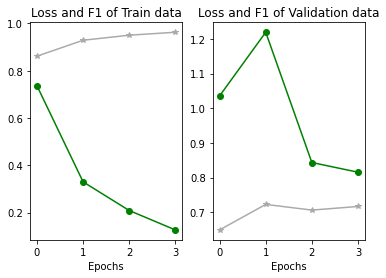

[I 2022-06-02 01:48:46,340] Trial 21 finished with value: 0.7223772551391475 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00029317478141001346, 'weight_decay': 6.041632487554555e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00024268727623859057, weight_decay : 7.983811899781417e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001999186, Avg Loss : 0.8286, f1 score : 0.8723
Epoch 0 Total Mean Loss : 0.7075
Epoch 0 Total Mean f1 : 0.8844
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8515 Valid Acc : 0.7211 Valid f1 : 0.6978
pearson 상관 계수 ; tensor([[1.0000, 0.7804],
        [0.7804, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001392468, Avg Loss : 0.3233, f1 score : 0.9300
Epoch 1 Total Mean Loss : 0.3122
Epoch 1 Total Mean f1 : 0.9284
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0212 Valid Acc : 0.7193 Valid f1 : 0.7412
pearson 상관 계수 ; tensor([[1.0000, 0.7767],
        [0.7767, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

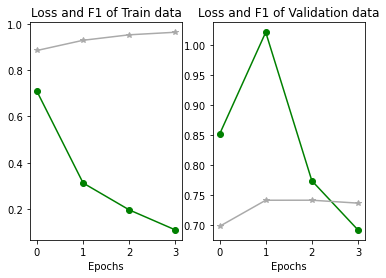

[I 2022-06-02 01:59:58,852] Trial 22 finished with value: 0.7412948466497968 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00024268727623859057, 'weight_decay': 7.983811899781417e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00013304685900544845, weight_decay : 5.600072142628064e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001096001, Avg Loss : 0.6359, f1 score : 0.8872
Epoch 0 Total Mean Loss : 0.5480
Epoch 0 Total Mean f1 : 0.8982
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9251 Valid Acc : 0.7138 Valid f1 : 0.7022
pearson 상관 계수 ; tensor([[1.0000, 0.7588],
        [0.7588, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000763384, Avg Loss : 0.2142, f1 score : 0.9453
Epoch 1 Total Mean Loss : 0.2068
Epoch 1 Total Mean f1 : 0.9471
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8662 Valid Acc : 0.7468 Valid f1 : 0.7588
pearson 상관 계수 ; tensor([[1.0000, 0.7985],
        [0.7985, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

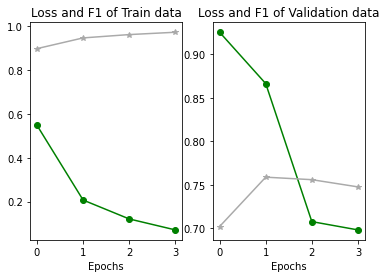

[I 2022-06-02 02:11:10,278] Trial 23 finished with value: 0.7588321604745561 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00013304685900544845, 'weight_decay': 5.600072142628064e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00013311687748713167, weight_decay : 5.47946961070268e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001096578, Avg Loss : 0.5908, f1 score : 0.8976
Epoch 0 Total Mean Loss : 0.5271
Epoch 0 Total Mean f1 : 0.9014
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0514 Valid Acc : 0.6998 Valid f1 : 0.7158
pearson 상관 계수 ; tensor([[1.0000, 0.7659],
        [0.7659, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000763785, Avg Loss : 0.2229, f1 score : 0.9461
Epoch 1 Total Mean Loss : 0.2193
Epoch 1 Total Mean f1 : 0.9466
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9251 Valid Acc : 0.7174 Valid f1 : 0.7156
pearson 상관 계수 ; tensor([[1.0000, 0.7842],
        [0.7842, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

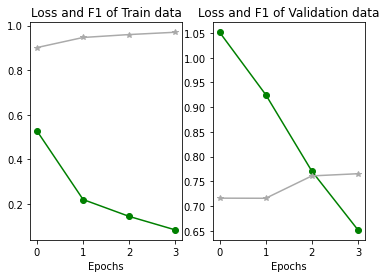

[I 2022-06-02 02:22:21,818] Trial 24 finished with value: 0.765276584519865 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00013311687748713167, 'weight_decay': 5.47946961070268e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8.030041515010791e-05, weight_decay : 9.894676253084684e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000661491, Avg Loss : 0.5553, f1 score : 0.9071
Epoch 0 Total Mean Loss : 0.4888
Epoch 0 Total Mean f1 : 0.9119
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.7708 Valid Acc : 0.7377 Valid f1 : 0.6924
pearson 상관 계수 ; tensor([[1.0000, 0.7982],
        [0.7982, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000460740, Avg Loss : 0.1982, f1 score : 0.9491
Epoch 1 Total Mean Loss : 0.1932
Epoch 1 Total Mean f1 : 0.9483
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7710 Valid Acc : 0.7560 Valid f1 : 0.7602
pearson 상관 계수 ; tensor([[1.0000, 0.8196],
        [0.8196, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

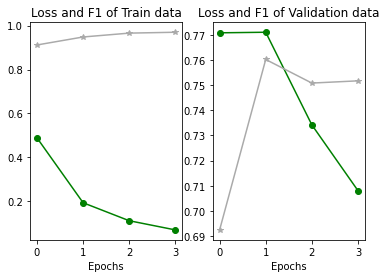

[I 2022-06-02 02:33:33,325] Trial 25 finished with value: 0.7601650201972189 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8.030041515010791e-05, 'weight_decay': 9.894676253084684e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 7.639402230312834e-05, weight_decay : 9.506226254011589e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000629311, Avg Loss : 0.6688, f1 score : 0.8969
Epoch 0 Total Mean Loss : 0.5607
Epoch 0 Total Mean f1 : 0.9041
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.7601 Valid Acc : 0.7524 Valid f1 : 0.7318
pearson 상관 계수 ; tensor([[1.0000, 0.8112],
        [0.8112, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000438326, Avg Loss : 0.1860, f1 score : 0.9511
Epoch 1 Total Mean Loss : 0.1820
Epoch 1 Total Mean f1 : 0.9534
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9922 Valid Acc : 0.7174 Valid f1 : 0.7354
pearson 상관 계수 ; tensor([[1.0000, 0.7885],
        [0.7885, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

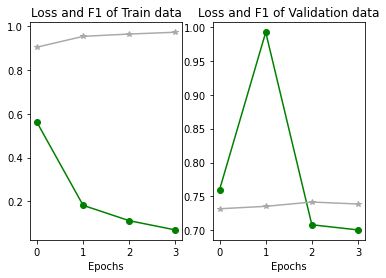

[I 2022-06-02 02:44:47,130] Trial 26 finished with value: 0.7417278248339577 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 7.639402230312834e-05, 'weight_decay': 9.506226254011589e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8.056284875213392e-05, weight_decay : 0.00015642437730095811, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000663653, Avg Loss : 0.6129, f1 score : 0.8825
Epoch 0 Total Mean Loss : 0.5274
Epoch 0 Total Mean f1 : 0.8945
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8872 Valid Acc : 0.7248 Valid f1 : 0.7231
pearson 상관 계수 ; tensor([[1.0000, 0.7858],
        [0.7858, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000462246, Avg Loss : 0.1952, f1 score : 0.9501
Epoch 1 Total Mean Loss : 0.1896
Epoch 1 Total Mean f1 : 0.9508
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7269 Valid Acc : 0.7487 Valid f1 : 0.7330
pearson 상관 계수 ; tensor([[1.0000, 0.8213],
        [0.8213, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

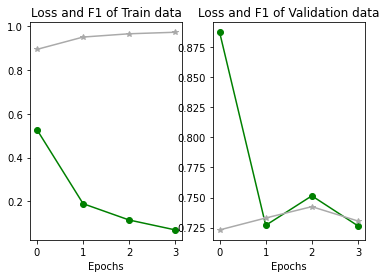

[I 2022-06-02 02:56:01,605] Trial 27 finished with value: 0.742413825601983 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8.056284875213392e-05, 'weight_decay': 0.00015642437730095811}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0004935820839560823, weight_decay : 0.00024272747745333434, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004065984, Avg Loss : 1.4548, f1 score : 0.7648
Epoch 0 Total Mean Loss : 1.2887
Epoch 0 Total Mean f1 : 0.7880
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.4042 Valid Acc : 0.6917 Valid f1 : 0.7098
pearson 상관 계수 ; tensor([[1.0000, 0.6816],
        [0.6816, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0002832028, Avg Loss : 0.6679, f1 score : 0.8863
Epoch 1 Total Mean Loss : 0.6486
Epoch 1 Total Mean f1 : 0.8889
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.2570 Valid Acc : 0.7046 Valid f1 : 0.7079
pearson 상관 계수 ; tensor([[1.0000, 0.7268],
        [0.7268, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train S

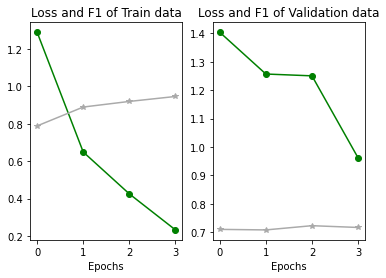

[I 2022-06-02 03:07:11,842] Trial 28 finished with value: 0.7227527983401965 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0004935820839560823, 'weight_decay': 0.00024272747745333434}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0002205300360118742, weight_decay : 7.032022620714891e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001816661, Avg Loss : 0.7174, f1 score : 0.8788
Epoch 0 Total Mean Loss : 0.6326
Epoch 0 Total Mean f1 : 0.8868
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.4350 Valid Acc : 0.6457 Valid f1 : 0.6901
pearson 상관 계수 ; tensor([[1.0000, 0.6964],
        [0.6964, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001265336, Avg Loss : 0.2729, f1 score : 0.9366
Epoch 1 Total Mean Loss : 0.2653
Epoch 1 Total Mean f1 : 0.9386
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0979 Valid Acc : 0.7230 Valid f1 : 0.7363
pearson 상관 계수 ; tensor([[1.0000, 0.7816],
        [0.7816, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

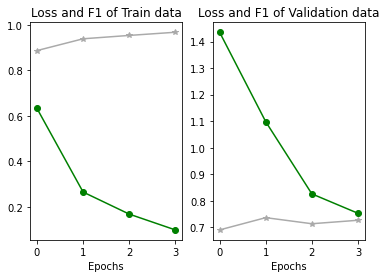

[I 2022-06-02 03:18:25,293] Trial 29 finished with value: 0.7362723437296878 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0002205300360118742, 'weight_decay': 7.032022620714891e-05}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 7.68489409963592e-05, weight_decay : 0.00010244290144997527, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000633059, Avg Loss : 0.5451, f1 score : 0.9007
Epoch 0 Total Mean Loss : 0.4838
Epoch 0 Total Mean f1 : 0.9053
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8816 Valid Acc : 0.7201 Valid f1 : 0.7165
pearson 상관 계수 ; tensor([[1.0000, 0.7756],
        [0.7756, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000440937, Avg Loss : 0.1881, f1 score : 0.9489
Epoch 1 Total Mean Loss : 0.1888
Epoch 1 Total Mean f1 : 0.9503
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8488 Valid Acc : 0.7340 Valid f1 : 0.7417
pearson 상관 계수 ; tensor([[1.0000, 0.8095],
        [0.8095, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train St

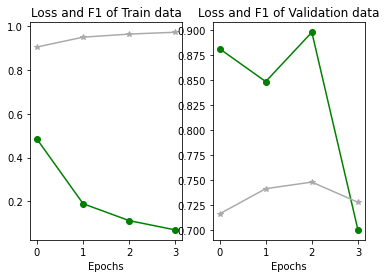

[I 2022-06-02 03:29:39,083] Trial 30 finished with value: 0.7482814005183722 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 7.68489409963592e-05, 'weight_decay': 0.00010244290144997527}. Best is trial 1 with value: 0.7718284836472763.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.00012811208951039397, weight_decay : 5.5007207553284445e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001055350, Avg Loss : 1.5061, f1 score : 0.6687
Epoch 0 Total Mean Loss : 1.1740
Epoch 0 Total Mean f1 : 0.7416
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1658 Valid Acc : 0.7082 Valid f1 : 0.7293
pearson 상관 계수 ; tensor([[1.0000, 0.7713],
        [0.7713, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000735069, Avg Loss : 0.2506, f1 score : 0.9424
Epoch 1 Total Mean Loss : 0.2440
Epoch 1 Total Mean f1 : 0.9425
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9025 Valid Acc : 0.7266 Valid f1 : 0.7301
pearson 상관 계수 ; tensor([[1.0000, 0.7953],
        [0.7953, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train 

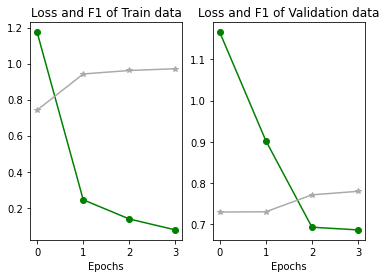

[I 2022-06-02 03:40:54,169] Trial 31 finished with value: 0.7797511875033644 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00012811208951039397, 'weight_decay': 5.5007207553284445e-05}. Best is trial 31 with value: 0.7797511875033644.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [49]:
print('snunlp/KR-Medium\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

[I 2022-06-01 08:30:26,523] A new study created in memory with name: hyper-parameter-search


snunlp/KR-Medium




Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/140k [00:00<?, ?B/s]

batch_size : 32
batch_size : 32


Downloading:   0%|          | 0.00/389M [00:00<?, ?B/s]

Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000191096, Avg Loss : 1.2854, f1 score : 0.8372
Epoch: 0, Step : 128, LR : 0.0000182329, Avg Loss : 0.4109, f1 score : 0.9094
Epoch: 0, Step : 192, LR : 0.0000173562, Avg Loss : 0.4090, f1 score : 0.9012
Epoch: 0, Step : 256, LR : 0.0000164795, Avg Loss : 0.3352, f1 score : 0.9273
Epoch: 0, Step : 320, LR : 0.0000156027, Avg Loss : 0.3402, f1 score : 0.9233
Epoch 0 Total Mean Loss : 0.5306
Epoch 0 Total Mean f1 : 0.9023
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0626 Valid Acc : 0.6752 Valid f1 : 0.6972
pearson 상관 계수 ; tensor([[1.0000, 0.7592],
        [0.7592, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000141096, Avg Loss : 0.2224, f1 score : 0.9476
Epoch: 1, Step : 128, LR : 0.0000132329, Avg Loss :

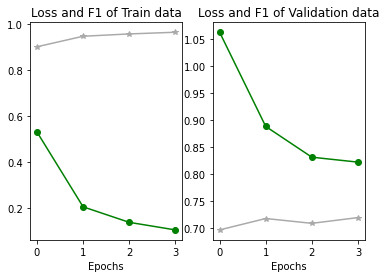

[I 2022-06-01 08:42:06,682] Trial 0 finished with value: 0.7199463295054922 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000955479, Avg Loss : 0.9780, f1 score : 0.8677
Epoch: 0, Step : 128, LR : 0.0000911644, Avg Loss : 0.4741, f1 score : 0.9133
Epoch: 0, Step : 192, LR : 0.0000867808, Avg Loss : 0.4655, f1 score : 0.8966
Epoch: 0, Step : 256, LR : 0.0000823973, Avg Loss : 0.3670, f1 score : 0.9205
Epoch: 0, Step : 320, LR : 0.0000780137, Avg Loss : 0.3539, f1 score : 0.9216
Epoch 0 Total Mean Loss : 0.5092
Epoch 0 Total Mean f1 : 0.9058
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9362 Valid Acc : 0.7340 Valid f1 : 0.7426
pearson 상관 계수 ; tensor([[1.0000, 0.7763],
        [0.7763, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9362_f1:0.7426.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64,

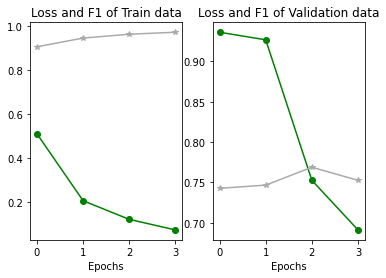

[I 2022-06-01 08:53:31,394] Trial 1 finished with value: 0.7687984527157616 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000955479, Avg Loss : 0.8185, f1 score : 0.8557
Epoch: 0, Step : 128, LR : 0.0000911644, Avg Loss : 0.5095, f1 score : 0.9080
Epoch: 0, Step : 192, LR : 0.0000867808, Avg Loss : 0.4443, f1 score : 0.9054
Epoch: 0, Step : 256, LR : 0.0000823973, Avg Loss : 0.3546, f1 score : 0.9164
Epoch: 0, Step : 320, LR : 0.0000780137, Avg Loss : 0.3654, f1 score : 0.9149
Epoch 0 Total Mean Loss : 0.4829
Epoch 0 Total Mean f1 : 0.9041
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0922 Valid Acc : 0.6843 Valid f1 : 0.7146
pearson 상관 계수 ; tensor([[1.0000, 0.7543],
        [0.7543, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:1.0922_f1:0.7146.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64,

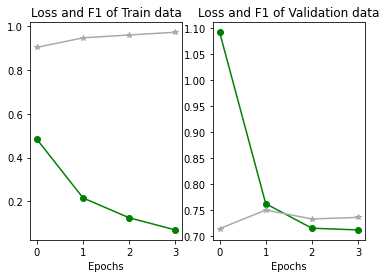

[I 2022-06-01 09:04:51,324] Trial 2 finished with value: 0.7503635358613784 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000911202, Avg Loss : 0.7448, f1 score : 0.8720
Epoch: 0, Step : 128, LR : 0.0000823770, Avg Loss : 0.3704, f1 score : 0.9270
Epoch 0 Total Mean Loss : 0.4947
Epoch 0 Total Mean f1 : 0.9050
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.7825 Valid Acc : 0.7432 Valid f1 : 0.7329
pearson 상관 계수 ; tensor([[1.0000, 0.7986],
        [0.7986, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.7825_f1:0.7329.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000661202, Avg Loss : 0.2119, f1 score : 0.9411
Epoch: 1, Step : 128, LR : 0.0000573770, Avg Loss : 0.1908, f1 score : 0.9505
Epoch 1 Total Mean Loss : 0.1917
Epoch 1 Total Mean f1 : 0.9496
*****Epoch 1 Train Finish*****

****

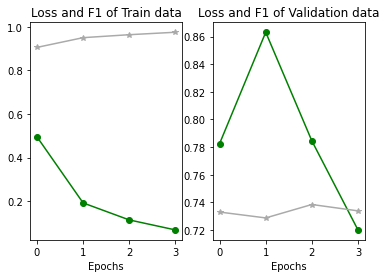

[I 2022-06-01 09:16:12,822] Trial 3 finished with value: 0.7383847700424945 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000191096, Avg Loss : 1.1205, f1 score : 0.8631
Epoch: 0, Step : 128, LR : 0.0000182329, Avg Loss : 0.4452, f1 score : 0.8948
Epoch: 0, Step : 192, LR : 0.0000173562, Avg Loss : 0.3712, f1 score : 0.9221
Epoch: 0, Step : 256, LR : 0.0000164795, Avg Loss : 0.3370, f1 score : 0.9210
Epoch: 0, Step : 320, LR : 0.0000156027, Avg Loss : 0.3431, f1 score : 0.9192
Epoch 0 Total Mean Loss : 0.4972
Epoch 0 Total Mean f1 : 0.9075
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9251 Valid Acc : 0.7046 Valid f1 : 0.7033
pearson 상관 계수 ; tensor([[1.0000, 0.7724],
        [0.7724, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9251_f1:0.7033.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, 

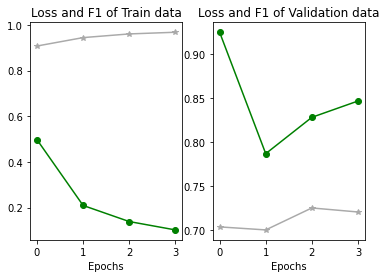

[I 2022-06-01 09:27:32,214] Trial 4 finished with value: 0.7249002681332839 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 5e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000477740, Avg Loss : 0.8353, f1 score : 0.8519
Epoch: 0, Step : 128, LR : 0.0000455822, Avg Loss : 0.3720, f1 score : 0.9021
Epoch: 0, Step : 192, LR : 0.0000433904, Avg Loss : 0.3515, f1 score : 0.9163
Epoch: 0, Step : 256, LR : 0.0000411986, Avg Loss : 0.3414, f1 score : 0.9276
Epoch: 0, Step : 320, LR : 0.0000390068, Avg Loss : 0.3280, f1 score : 0.9228
Epoch 0 Total Mean Loss : 0.4286
Epoch 0 Total Mean f1 : 0.9066
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.7450 Valid Acc : 0.7524 Valid f1 : 0.7321
pearson 상관 계수 ; tensor([[1.0000, 0.8055],
        [0.8055, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.7450_f1:0.7321.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, 

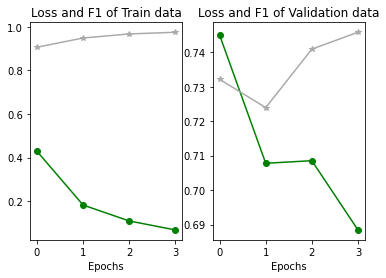

[I 2022-06-01 09:38:55,447] Trial 5 finished with value: 0.7457985537970313 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 3e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000293322, Avg Loss : 1.3199, f1 score : 0.8152
Epoch: 0, Step : 128, LR : 0.0000286747, Avg Loss : 0.4432, f1 score : 0.9047
Epoch: 0, Step : 192, LR : 0.0000280171, Avg Loss : 0.4338, f1 score : 0.9062
Epoch: 0, Step : 256, LR : 0.0000273596, Avg Loss : 0.4181, f1 score : 0.8939
Epoch: 0, Step : 320, LR : 0.0000267021, Avg Loss : 0.3731, f1 score : 0.9117
Epoch: 0, Step : 384, LR : 0.0000260445, Avg Loss : 0.3939, f1 score : 0.8972
Epoch: 0, Step : 448, LR : 0.0000253870, Avg Loss : 0.3491, f1 score : 0.9172
Epoch: 0, Step : 512, LR : 0.0000247295, Avg Loss : 0.3558, f1 score : 0.9342
Epoch: 0, Step : 576, LR : 0.0000240719, Avg Loss : 0.2733, f1 score : 0.9243
Epoch: 0, Step : 640, LR : 0.0000234144, Avg Loss : 0.2951, f1 score : 0.9335
Epoch: 0, Step : 704, LR : 0.0000227568, Avg Loss : 0.2884, f1 score : 0.9420

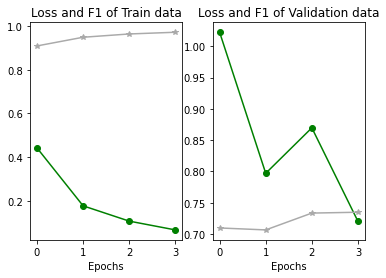

[I 2022-06-01 09:50:39,078] Trial 6 finished with value: 0.7349501602451632 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05}. Best is trial 0 with value: 0.7199463295054922.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 2.0134, f1 score : 0.8214
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4505, f1 score : 0.8967
Epoch 0 Total Mean Loss : 0.9953
Epoch 0 Total Mean f1 : 0.8739
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0092 Valid Acc : 0.6809 Valid f1 : 0.6601
pearson 상관 계수 ; tensor([[1.0000, 0.7374],
        [0.7374, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3138, f1 score : 0.9273
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3220, f1 score : 0.9201
Epoch 1 Total Mean Loss : 0.3070
Epoch 1 Total Mean f1 : 0.9262
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0760 Valid Acc : 0.6605 Valid f1 : 0.6673
pearson 상관 계수 ; t

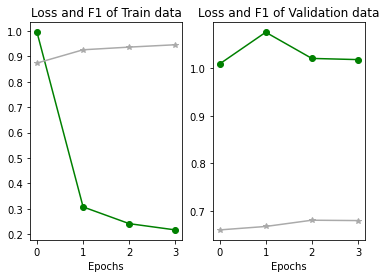

[I 2022-06-01 10:01:51,779] Trial 7 finished with value: 0.6804628158523875 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 7 with value: 0.6804628158523875.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000191096, Avg Loss : 1.3358, f1 score : 0.8381
Epoch: 0, Step : 128, LR : 0.0000182329, Avg Loss : 0.4293, f1 score : 0.9013
Epoch: 0, Step : 192, LR : 0.0000173562, Avg Loss : 0.3712, f1 score : 0.9184
Epoch: 0, Step : 256, LR : 0.0000164795, Avg Loss : 0.3344, f1 score : 0.9260
Epoch: 0, Step : 320, LR : 0.0000156027, Avg Loss : 0.3421, f1 score : 0.9219
Epoch 0 Total Mean Loss : 0.5341
Epoch 0 Total Mean f1 : 0.9052
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0246 Valid Acc : 0.6991 Valid f1 : 0.7144
pearson 상관 계수 ; tensor([[1.0000, 0.7662],
        [0.7662, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:1.0246_f1:0.7144.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, 

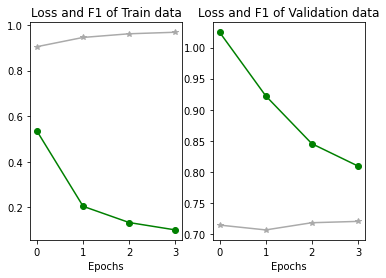

[I 2022-06-01 10:13:15,897] Trial 8 finished with value: 0.7203829390331399 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05}. Best is trial 7 with value: 0.6804628158523875.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000191096, Avg Loss : 1.3879, f1 score : 0.8266
Epoch: 0, Step : 128, LR : 0.0000182329, Avg Loss : 0.4561, f1 score : 0.8951
Epoch: 0, Step : 192, LR : 0.0000173562, Avg Loss : 0.4000, f1 score : 0.9116
Epoch: 0, Step : 256, LR : 0.0000164795, Avg Loss : 0.3322, f1 score : 0.9267
Epoch: 0, Step : 320, LR : 0.0000156027, Avg Loss : 0.3034, f1 score : 0.9290
Epoch 0 Total Mean Loss : 0.5480
Epoch 0 Total Mean f1 : 0.9003
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0442 Valid Acc : 0.6935 Valid f1 : 0.7104
pearson 상관 계수 ; tensor([[1.0000, 0.7676],
        [0.7676, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:1.0442_f1:0.7104.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, 

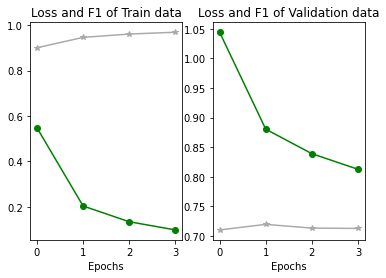

[I 2022-06-01 10:24:36,904] Trial 9 finished with value: 0.7197348730575504 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05}. Best is trial 7 with value: 0.6804628158523875.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.7193, f1 score : 0.8315
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4522, f1 score : 0.8911
Epoch 0 Total Mean Loss : 0.8826
Epoch 0 Total Mean f1 : 0.8755
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1746 Valid Acc : 0.6549 Valid f1 : 0.6660
pearson 상관 계수 ; tensor([[1.0000, 0.7225],
        [0.7225, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3135, f1 score : 0.9225
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3124, f1 score : 0.9201
Epoch 1 Total Mean Loss : 0.3069
Epoch 1 Total Mean f1 : 0.9230
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0259 Valid Acc : 0.6733 Valid f1 : 0.6739
pearson 상관 계수 ; t

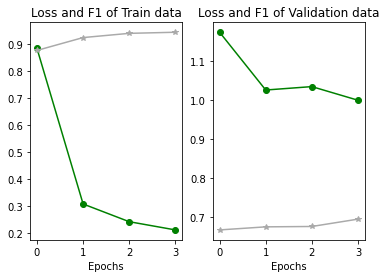

[I 2022-06-01 10:35:49,929] Trial 10 finished with value: 0.6937176754524292 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 7 with value: 0.6804628158523875.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.8841, f1 score : 0.8303
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4722, f1 score : 0.8934
Epoch 0 Total Mean Loss : 0.9565
Epoch 0 Total Mean f1 : 0.8727
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1398 Valid Acc : 0.6457 Valid f1 : 0.6423
pearson 상관 계수 ; tensor([[1.0000, 0.7175],
        [0.7175, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3171, f1 score : 0.9256
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.2986, f1 score : 0.9225
Epoch 1 Total Mean Loss : 0.3047
Epoch 1 Total Mean f1 : 0.9228
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.1195 Valid Acc : 0.6641 Valid f1 : 0.6768
pearson 상관 계수 ; t

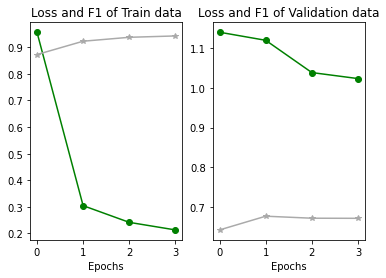

[I 2022-06-01 10:47:02,131] Trial 11 finished with value: 0.6768167670495506 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.8985, f1 score : 0.8199
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4826, f1 score : 0.8846
Epoch 0 Total Mean Loss : 0.9481
Epoch 0 Total Mean f1 : 0.8704
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1138 Valid Acc : 0.6670 Valid f1 : 0.6622
pearson 상관 계수 ; tensor([[1.0000, 0.7258],
        [0.7258, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3159, f1 score : 0.9210
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3066, f1 score : 0.9248
Epoch 1 Total Mean Loss : 0.3064
Epoch 1 Total Mean f1 : 0.9239
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0857 Valid Acc : 0.6568 Valid f1 : 0.6692
pearson 상관 계수 ; t

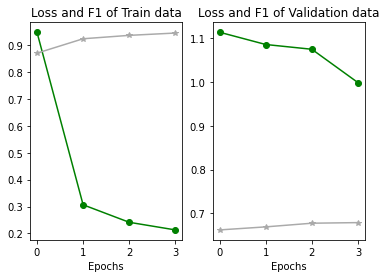

[I 2022-06-01 10:58:15,645] Trial 12 finished with value: 0.6789040212572608 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.9311, f1 score : 0.8227
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4805, f1 score : 0.8947
Epoch 0 Total Mean Loss : 0.9690
Epoch 0 Total Mean f1 : 0.8730
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0257 Valid Acc : 0.6880 Valid f1 : 0.6660
pearson 상관 계수 ; tensor([[1.0000, 0.7291],
        [0.7291, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3215, f1 score : 0.9245
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.2916, f1 score : 0.9259
Epoch 1 Total Mean Loss : 0.3011
Epoch 1 Total Mean f1 : 0.9253
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0529 Valid Acc : 0.6494 Valid f1 : 0.6568
pearson 상관 계수 ; t

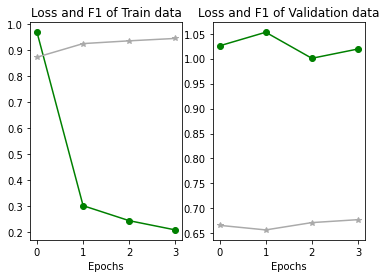

[I 2022-06-01 11:09:27,846] Trial 13 finished with value: 0.6773261987069943 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.7282, f1 score : 0.8423
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4745, f1 score : 0.8975
Epoch 0 Total Mean Loss : 0.8932
Epoch 0 Total Mean f1 : 0.8810
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.2306 Valid Acc : 0.6347 Valid f1 : 0.6495
pearson 상관 계수 ; tensor([[1.0000, 0.7174],
        [0.7174, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3124, f1 score : 0.9141
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3054, f1 score : 0.9270
Epoch 1 Total Mean Loss : 0.3106
Epoch 1 Total Mean f1 : 0.9242
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.2265 Valid Acc : 0.6513 Valid f1 : 0.6769
pearson 상관 계수 ; t

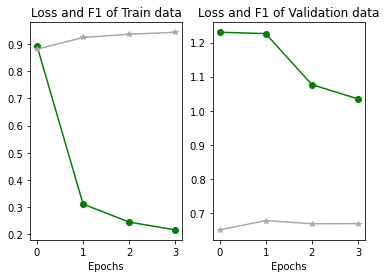

[I 2022-06-01 11:20:40,409] Trial 14 finished with value: 0.6768875294279818 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000078219, Avg Loss : 2.4024, f1 score : 0.8040
Epoch: 0, Step : 128, LR : 0.0000076466, Avg Loss : 0.5606, f1 score : 0.8651
Epoch: 0, Step : 192, LR : 0.0000074712, Avg Loss : 0.4477, f1 score : 0.8958
Epoch: 0, Step : 256, LR : 0.0000072959, Avg Loss : 0.4132, f1 score : 0.8960
Epoch: 0, Step : 320, LR : 0.0000071205, Avg Loss : 0.3832, f1 score : 0.8975
Epoch: 0, Step : 384, LR : 0.0000069452, Avg Loss : 0.3786, f1 score : 0.9111
Epoch: 0, Step : 448, LR : 0.0000067699, Avg Loss : 0.3891, f1 score : 0.9048
Epoch: 0, Step : 512, LR : 0.0000065945, Avg Loss : 0.3703, f1 score : 0.9180
Epoch: 0, Step : 576, LR : 0.0000064192, Avg Loss : 0.4077, f1 score : 0.8932
Epoch: 0, Step : 640, LR : 0.0000062438, Avg Loss : 0.3445, f1 score : 0.9146
Epoch: 0, Step : 704, LR : 0.0000060685, Avg Loss : 0.3497, f1 score : 0.9145

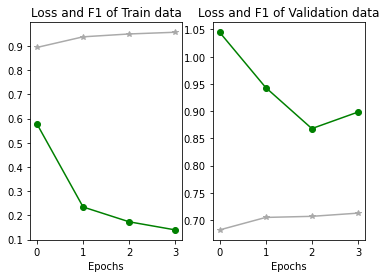

[I 2022-06-01 11:32:26,005] Trial 15 finished with value: 0.7126943766217123 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 8e-06}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 5e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000455601, Avg Loss : 0.8753, f1 score : 0.8752
Epoch: 0, Step : 128, LR : 0.0000411885, Avg Loss : 0.3537, f1 score : 0.9193
Epoch 0 Total Mean Loss : 0.5266
Epoch 0 Total Mean f1 : 0.9064
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8540 Valid Acc : 0.7358 Valid f1 : 0.7316
pearson 상관 계수 ; tensor([[1.0000, 0.7997],
        [0.7997, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.8540_f1:0.7316.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000330601, Avg Loss : 0.1882, f1 score : 0.9542
Epoch: 1, Step : 128, LR : 0.0000286885, Avg Loss : 0.2058, f1 score : 0.9492
Epoch 1 Total Mean Loss : 0.1892
Epoch 1 Total Mean f1 : 0.9513
*****Epoch 1 Train Finish*****

*****

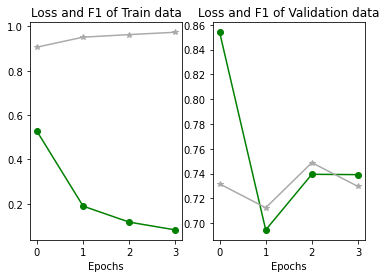

[I 2022-06-01 11:43:43,667] Trial 16 finished with value: 0.7487865064084414 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5e-05}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 3e-05, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000273361, Avg Loss : 0.9659, f1 score : 0.8616
Epoch: 0, Step : 128, LR : 0.0000247131, Avg Loss : 0.3759, f1 score : 0.9137
Epoch 0 Total Mean Loss : 0.5659
Epoch 0 Total Mean f1 : 0.8991
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9694 Valid Acc : 0.6917 Valid f1 : 0.6997
pearson 상관 계수 ; tensor([[1.0000, 0.7698],
        [0.7698, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000198361, Avg Loss : 0.1967, f1 score : 0.9485
Epoch: 1, Step : 128, LR : 0.0000172131, Avg Loss : 0.2102, f1 score : 0.9429
Epoch 1 Total Mean Loss : 0.2056
Epoch 1 Total Mean f1 : 0.9470
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8743 Valid Acc : 0.7174 Valid f1 : 0.7169
pearson 상관 계수 ; t

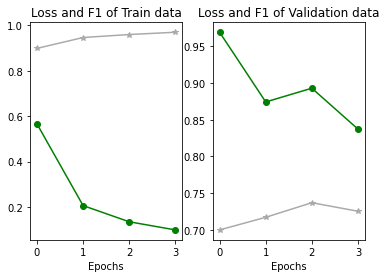

[I 2022-06-01 11:55:06,291] Trial 17 finished with value: 0.7368573504159276 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 3e-05}. Best is trial 11 with value: 0.6768167670495506.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.7916, f1 score : 0.8291
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4638, f1 score : 0.8967
Epoch 0 Total Mean Loss : 0.9169
Epoch 0 Total Mean f1 : 0.8753
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1748 Valid Acc : 0.6476 Valid f1 : 0.6598
pearson 상관 계수 ; tensor([[1.0000, 0.7209],
        [0.7209, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3074, f1 score : 0.9295
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3074, f1 score : 0.9253
Epoch 1 Total Mean Loss : 0.3095
Epoch 1 Total Mean f1 : 0.9278
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.1021 Valid Acc : 0.6439 Valid f1 : 0.6561
pearson 상관 계수 ; t

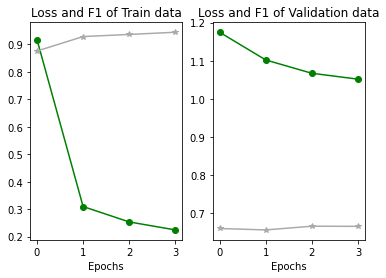

[I 2022-06-01 12:06:21,446] Trial 18 finished with value: 0.6657968200734514 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 18 with value: 0.6657968200734514.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000078219, Avg Loss : 2.3726, f1 score : 0.8110
Epoch: 0, Step : 128, LR : 0.0000076466, Avg Loss : 0.5179, f1 score : 0.8804
Epoch: 0, Step : 192, LR : 0.0000074712, Avg Loss : 0.5476, f1 score : 0.8849
Epoch: 0, Step : 256, LR : 0.0000072959, Avg Loss : 0.4901, f1 score : 0.8841
Epoch: 0, Step : 320, LR : 0.0000071205, Avg Loss : 0.4331, f1 score : 0.8841
Epoch: 0, Step : 384, LR : 0.0000069452, Avg Loss : 0.4321, f1 score : 0.9011
Epoch: 0, Step : 448, LR : 0.0000067699, Avg Loss : 0.3428, f1 score : 0.9172
Epoch: 0, Step : 512, LR : 0.0000065945, Avg Loss : 0.3669, f1 score : 0.9119
Epoch: 0, Step : 576, LR : 0.0000064192, Avg Loss : 0.3807, f1 score : 0.9128
Epoch: 0, Step : 640, LR : 0.0000062438, Avg Loss : 0.3384, f1 score : 0.9113
Epoch: 0, Step : 704, LR : 0.0000060685, Avg Loss : 0.3352, f1 score : 0.8999

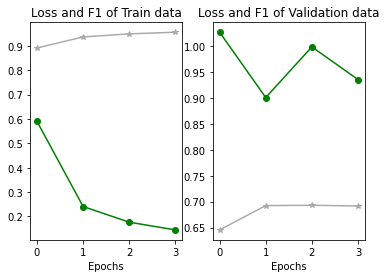

[I 2022-06-01 12:17:53,452] Trial 19 finished with value: 0.6929939234325885 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 8e-06}. Best is trial 18 with value: 0.6657968200734514.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.8511, f1 score : 0.8248
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4677, f1 score : 0.8934
Epoch 0 Total Mean Loss : 0.9458
Epoch 0 Total Mean f1 : 0.8717
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0828 Valid Acc : 0.6513 Valid f1 : 0.6257
pearson 상관 계수 ; tensor([[1.0000, 0.7189],
        [0.7189, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3033, f1 score : 0.9304
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3187, f1 score : 0.9184
Epoch 1 Total Mean Loss : 0.3124
Epoch 1 Total Mean f1 : 0.9226
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0991 Valid Acc : 0.6586 Valid f1 : 0.6775
pearson 상관 계수 ; t

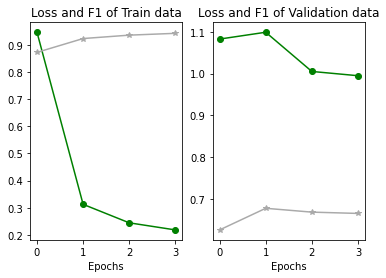

[I 2022-06-01 12:29:06,426] Trial 20 finished with value: 0.6774637751713875 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 18 with value: 0.6657968200734514.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.8881, f1 score : 0.8188
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4730, f1 score : 0.8974
Epoch 0 Total Mean Loss : 0.9514
Epoch 0 Total Mean f1 : 0.8732
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1541 Valid Acc : 0.6578 Valid f1 : 0.6752
pearson 상관 계수 ; tensor([[1.0000, 0.7237],
        [0.7237, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3253, f1 score : 0.9225
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3128, f1 score : 0.9222
Epoch 1 Total Mean Loss : 0.3130
Epoch 1 Total Mean f1 : 0.9248
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0508 Valid Acc : 0.6678 Valid f1 : 0.6811
pearson 상관 계수 ; t

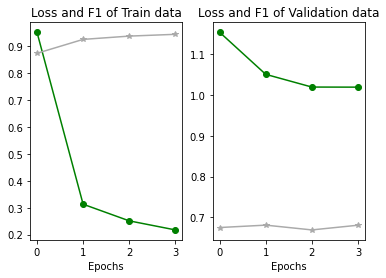

[I 2022-06-01 12:40:19,548] Trial 21 finished with value: 0.6810947919352683 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 18 with value: 0.6657968200734514.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.7384, f1 score : 0.8294
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4433, f1 score : 0.8968
Epoch 0 Total Mean Loss : 0.8863
Epoch 0 Total Mean f1 : 0.8768
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.2889 Valid Acc : 0.6476 Valid f1 : 0.6709
pearson 상관 계수 ; tensor([[1.0000, 0.7190],
        [0.7190, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3039, f1 score : 0.9304
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.3002, f1 score : 0.9202
Epoch 1 Total Mean Loss : 0.3045
Epoch 1 Total Mean f1 : 0.9262
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0270 Valid Acc : 0.6707 Valid f1 : 0.6611
pearson 상관 계수 ; t

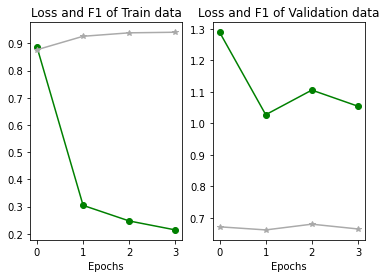

[I 2022-06-01 12:51:32,728] Trial 22 finished with value: 0.6793301550752047 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8e-06}. Best is trial 18 with value: 0.6657968200734514.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : snunlp/KR-Medium, lr : 8e-06, weight_decay : 4e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000072896, Avg Loss : 1.9261, f1 score : 0.8198
Epoch: 0, Step : 128, LR : 0.0000065902, Avg Loss : 0.4667, f1 score : 0.8904
Epoch 0 Total Mean Loss : 0.9610
Epoch 0 Total Mean f1 : 0.8731
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1488 Valid Acc : 0.6568 Valid f1 : 0.6711
pearson 상관 계수 ; tensor([[1.0000, 0.7224],
        [0.7224, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000052896, Avg Loss : 0.3113, f1 score : 0.9263
Epoch: 1, Step : 128, LR : 0.0000045902, Avg Loss : 0.2960, f1 score : 0.9319
Epoch 1 Total Mean Loss : 0.3089
Epoch 1 Total Mean f1 : 0.9275
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0439 Valid Acc : 0.6696 Valid f1 : 0.6721
pearson 상관 계수 ; t

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [25]:
print('snunlp/KR-Medium\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

### klue/bert-base
- train_batch_size = [16, 32, 64, 128]
- valid_batch_size = 32
- learning_rate = trial.suggest_loguniform('learning_rate', low=5e-5, high=5e-3)
- weight_decay = trial.suggest_loguniform('weight_decay', low=4e-5, high=1e-3)

**train_batch_size, validation_batch_size, lr, weight_decay, epoch -> f1 score**

4. 64, 32, 8e-05, 4e-04, 3 -> 0.7498
6. 32, 32, 1e-04, 6e-04, 2 -> 0.7592
8. 32, 32, 1e-04, 6e-04, 4 -> 0.7512
11. 32, 32, 8e-05, 8e-04, 4 -> **0.7653**
12. 32, 32, 5e-05, 8e-04, 3 -> **0.7791**
13. 32, 32, 6e-05, 2e-04, 3 -> 0.7586
14. 32, 32, 5e-05, 9e-04, 3 -> **0.7648**
15. 32, 32, 1e-04, 3e-04, 2 -> 0.7612
16. 16, 32, 8.9e-05, 7e-04, 4 -> 0.7543
18. 32, 32, 5e-05, 3e-04, 4 -> 0.7588
20. 32, 32, 2e-04, 5e-04, 4 -> 0.7018
21. 32, 32, 5e-05, 9e-04, 4 -> 0.7628
22. 32, 32, 9e-05, 7e-04, 4 -> **0.7703**
23. 32, 32, 9e-05, 6e-04, 2 -> 0.7377
24. 32, 32, 1e-04, 4e-04, 3 -> 0.7405
26. 32, 32, 8e-05, 3e-04, 4 -> 0.7633
29. 16, 32, 1e-04, 4e-04, 3 -> 0.7530
30. 16, 32, 7e-05, 4e-05, 4 -> 0.7633
31. 32, 32, 6e-05, 8e-04, 3 -> 0.7527

[I 2022-06-01 13:47:40,069] A new study created in memory with name: hyper-parameter-search


klue/bert-base


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 0.0002413759008436688, weight_decay : 7.518785496613016e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002307124, Avg Loss : 1.1879, f1 score : 0.7747
Epoch: 0, Step : 256, LR : 0.0002201315, Avg Loss : 0.9553, f1 score : 0.8364
Epoch: 0, Step : 384, LR : 0.0002095507, Avg Loss : 1.5649, f1 score : 0.6437
Epoch: 0, Step : 512, LR : 0.0001989698, Avg Loss : 3.1489, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0001883889, Avg Loss : 3.1276, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.1416
Epoch 0 Total Mean f1 : 0.3964
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1642 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.2096],
        [0.2096, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.13506007194519초
green is loss, gray is f1


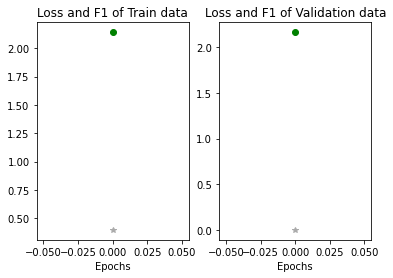

[I 2022-06-01 13:50:58,452] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0002413759008436688, 'weight_decay': 7.518785496613016e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 0.0006067519299343726, weight_decay : 0.00012783704478980902, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005799468, Avg Loss : 3.5773, f1 score : 0.0343
Epoch: 0, Step : 256, LR : 0.0005533494, Avg Loss : 3.2249, f1 score : 0.0358
Epoch: 0, Step : 384, LR : 0.0005267521, Avg Loss : 3.3181, f1 score : 0.0218
Epoch: 0, Step : 512, LR : 0.0005001548, Avg Loss : 3.1899, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0004735574, Avg Loss : 3.3366, f1 score : 0.0357
Epoch 0 Total Mean Loss : 3.3233
Epoch 0 Total Mean f1 : 0.0253
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4018 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0065],
        [0.0065, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 13.658421516418457초
green is loss, gray is f1


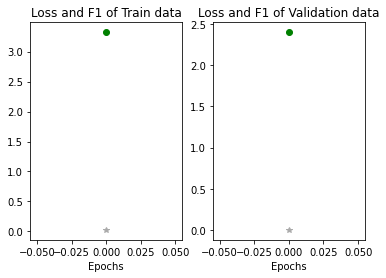

[I 2022-06-01 13:54:21,056] Trial 1 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0006067519299343726, 'weight_decay': 0.00012783704478980902}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.0011232367544937506, weight_decay : 0.0004439260258076185, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0010239919, Avg Loss : 3.8534, f1 score : 0.1189
Epoch: 0, Step : 256, LR : 0.0009255163, Avg Loss : 3.2592, f1 score : 0.0294
Epoch 0 Total Mean Loss : 3.5157
Epoch 0 Total Mean f1 : 0.0767
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.8003 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0007431827, Avg Loss : 3.2657, f1 score : 0.0372
Epoch: 1, Step : 256, LR : 0.0006447071, Avg Loss : 3.3061, f1 score : 0.0335
Epoch 1 Total Mean Loss : 3.2909
Epoch 1 Total Mean f1 : 0.0307
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 2.2982 Valid Acc : 0.5825 Valid f1 : 0.00

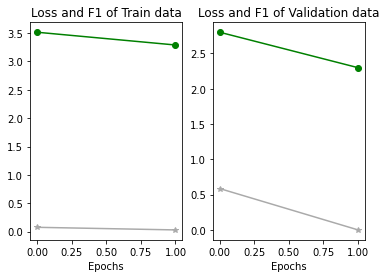

[I 2022-06-01 14:00:50,112] Trial 2 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0011232367544937506, 'weight_decay': 0.0004439260258076185}. Best is trial 2 with value: 0.585747622409982.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : klue/bert-base, lr : 0.00044310965349684704, weight_decay : 0.00011864398144898196, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0003650207, Avg Loss : 3.5114, f1 score : 0.0338
Epoch 0 Total Mean Loss : 3.3808
Epoch 0 Total Mean f1 : 0.0238
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1636 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0248],
        [-0.0248,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 10.43580436706543초
green is loss, gray is f1


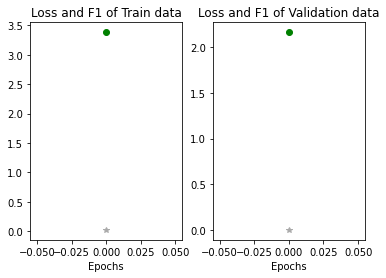

[I 2022-06-01 14:04:09,545] Trial 3 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00044310965349684704, 'weight_decay': 0.00011864398144898196}. Best is trial 2 with value: 0.585747622409982.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : klue/bert-base, lr : 8.026289025248814e-05, weight_decay : 0.00043732337612279604, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000661182, Avg Loss : 0.5748, f1 score : 0.8984
Epoch 0 Total Mean Loss : 0.5139
Epoch 0 Total Mean f1 : 0.9052
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9402 Valid Acc : 0.7450 Valid f1 : 0.7415
pearson 상관 계수 ; tensor([[1.0000, 0.7773],
        [0.7773, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000460525, Avg Loss : 0.1959, f1 score : 0.9481
Epoch 1 Total Mean Loss : 0.1971
Epoch 1 Total Mean f1 : 0.9493
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8718 Valid Acc : 0.7314 Valid f1 : 0.7065
pearson 상관 계수 ; tensor([[1.0000, 0.7747],
        [0.7747, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Sta

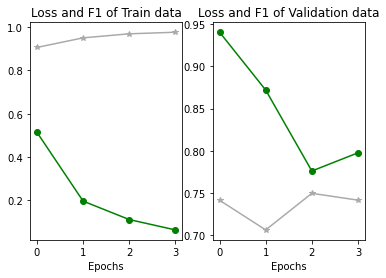

[I 2022-06-01 14:17:06,069] Trial 4 finished with value: 0.7497787144327843 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 8.026289025248814e-05, 'weight_decay': 0.00043732337612279604}. Best is trial 4 with value: 0.7497787144327843.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : klue/bert-base, lr : 0.0011963442912866307, weight_decay : 0.0002380268048885652, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0009855131, Avg Loss : 3.7173, f1 score : 0.0983
Epoch 0 Total Mean Loss : 3.6005
Epoch 0 Total Mean f1 : 0.0799
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4626 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0006864271, Avg Loss : 3.2266, f1 score : 0.0242
Epoch 1 Total Mean Loss : 3.2095
Epoch 1 Total Mean f1 : 0.0170
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 2.3007 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0181],
        [-0.0181,  1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

Train Finished
time : 6.0분 18.84

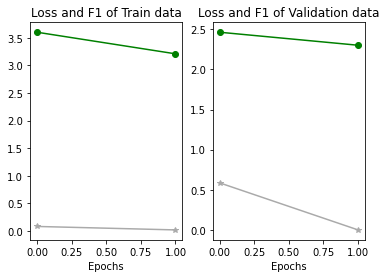

[I 2022-06-01 14:23:33,835] Trial 5 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0011963442912866307, 'weight_decay': 0.0002380268048885652}. Best is trial 4 with value: 0.7497787144327843.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00012558981387335747, weight_decay : 0.0006247378201671666, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001144932, Avg Loss : 0.7432, f1 score : 0.8779
Epoch: 0, Step : 256, LR : 0.0001034826, Avg Loss : 0.4569, f1 score : 0.9066
Epoch 0 Total Mean Loss : 0.5361
Epoch 0 Total Mean f1 : 0.9009
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9504 Valid Acc : 0.7487 Valid f1 : 0.7164
pearson 상관 계수 ; tensor([[1.0000, 0.7513],
        [0.7513, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000830957, Avg Loss : 0.2503, f1 score : 0.9414
Epoch: 1, Step : 256, LR : 0.0000720851, Avg Loss : 0.2245, f1 score : 0.9418
Epoch 1 Total Mean Loss : 0.2323
Epoch 1 Total Mean f1 : 0.9428
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.1348 Valid Acc : 0.7340 V

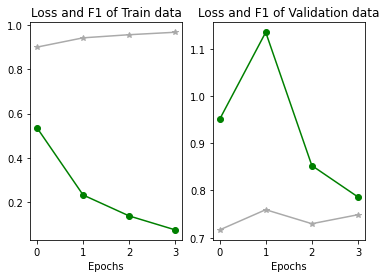

[I 2022-06-01 14:36:37,444] Trial 6 finished with value: 0.7592165739114284 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00012558981387335747, 'weight_decay': 0.0006247378201671666}. Best is trial 6 with value: 0.7592165739114284.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : klue/bert-base, lr : 0.0008264387473945252, weight_decay : 0.00047796317278309646, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0006807959, Avg Loss : 3.4518, f1 score : 0.0291
Epoch 0 Total Mean Loss : 3.3424
Epoch 0 Total Mean f1 : 0.0205
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1735 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0193],
        [0.0193, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 8.633944749832153초
green is loss, gray is f1


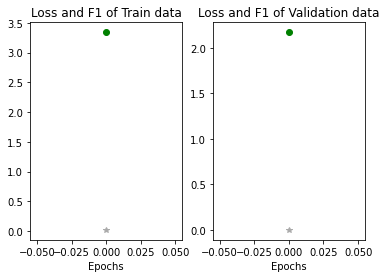

[I 2022-06-01 14:39:55,035] Trial 7 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0008264387473945252, 'weight_decay': 0.00047796317278309646}. Best is trial 6 with value: 0.7592165739114284.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00016847418755755545, weight_decay : 0.0006442039221145238, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001535885, Avg Loss : 0.8060, f1 score : 0.8564
Epoch: 0, Step : 256, LR : 0.0001388181, Avg Loss : 0.4802, f1 score : 0.8962
Epoch 0 Total Mean Loss : 0.5899
Epoch 0 Total Mean f1 : 0.8841
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.3688 Valid Acc : 0.6862 Valid f1 : 0.7152
pearson 상관 계수 ; tensor([[1.0000, 0.7270],
        [0.7270, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001114699, Avg Loss : 0.2877, f1 score : 0.9372
Epoch: 1, Step : 256, LR : 0.0000966996, Avg Loss : 0.2901, f1 score : 0.9373
Epoch 1 Total Mean Loss : 0.2856
Epoch 1 Total Mean f1 : 0.9334
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9756 Valid Acc : 0.7174 V

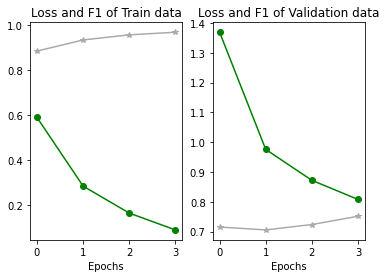

[I 2022-06-01 14:52:51,531] Trial 8 finished with value: 0.7512221851546618 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00016847418755755545, 'weight_decay': 0.0006442039221145238}. Best is trial 6 with value: 0.7592165739114284.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.0005068170356900965, weight_decay : 5.634596661491438e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004620366, Avg Loss : 3.3164, f1 score : 0.0281
Epoch: 0, Step : 256, LR : 0.0004176034, Avg Loss : 3.2005, f1 score : 0.0021
Epoch 0 Total Mean Loss : 3.2212
Epoch 0 Total Mean f1 : 0.0107
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2005 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0738],
        [0.0738, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.601450681686401초
green is loss, gray is f1


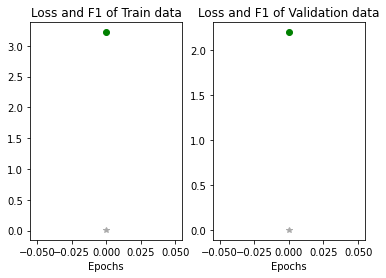

[I 2022-06-01 14:56:10,097] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0005068170356900965, 'weight_decay': 5.634596661491438e-05}. Best is trial 6 with value: 0.7592165739114284.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.004276682175154247, weight_decay : 0.0009092186945220509, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0038988109, Avg Loss : 4.3711, f1 score : 0.1468
Epoch: 0, Step : 256, LR : 0.0035238689, Avg Loss : 4.4059, f1 score : 0.2003
Epoch 0 Total Mean Loss : 4.3280
Epoch 0 Total Mean f1 : 0.1668
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3327 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 8.270991086959839초
green is loss, gray is f1


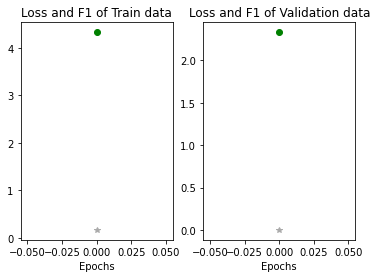

[I 2022-06-01 14:59:27,310] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.004276682175154247, 'weight_decay': 0.0009092186945220509}. Best is trial 6 with value: 0.7592165739114284.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 8.069221358038998e-05, weight_decay : 0.000816055858723232, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000735626, Avg Loss : 0.6881, f1 score : 0.8875
Epoch: 0, Step : 256, LR : 0.0000664882, Avg Loss : 0.3695, f1 score : 0.9292
Epoch 0 Total Mean Loss : 0.4755
Epoch 0 Total Mean f1 : 0.9122
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1998 Valid Acc : 0.7027 Valid f1 : 0.7270
pearson 상관 계수 ; tensor([[1.0000, 0.7357],
        [0.7357, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000533895, Avg Loss : 0.2117, f1 score : 0.9472
Epoch: 1, Step : 256, LR : 0.0000463151, Avg Loss : 0.1993, f1 score : 0.9456
Epoch 1 Total Mean Loss : 0.2029
Epoch 1 Total Mean f1 : 0.9466
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9134 Valid Acc : 0.7487 Val

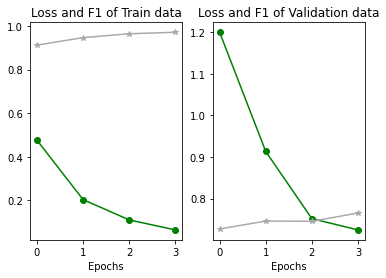

[I 2022-06-01 15:12:29,807] Trial 11 finished with value: 0.7653068966126385 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 8.069221358038998e-05, 'weight_decay': 0.000816055858723232}. Best is trial 11 with value: 0.7653068966126385.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 5.062561933423002e-05, weight_decay : 0.0008860446475103689, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000461525, Avg Loss : 0.6609, f1 score : 0.8891
Epoch: 0, Step : 256, LR : 0.0000417141, Avg Loss : 0.3672, f1 score : 0.9234
Epoch 0 Total Mean Loss : 0.4653
Epoch 0 Total Mean f1 : 0.9098
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0027 Valid Acc : 0.7156 Valid f1 : 0.7238
pearson 상관 계수 ; tensor([[1.0000, 0.7571],
        [0.7571, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000334961, Avg Loss : 0.2177, f1 score : 0.9467
Epoch: 1, Step : 256, LR : 0.0000290577, Avg Loss : 0.1877, f1 score : 0.9523
Epoch 1 Total Mean Loss : 0.2000
Epoch 1 Total Mean f1 : 0.9497
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8078 Valid Acc : 0.7450 Va

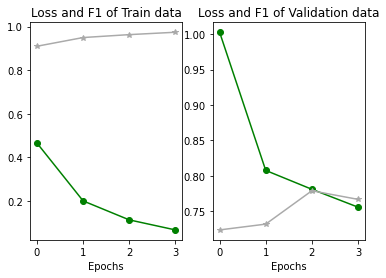

[I 2022-06-01 15:25:28,904] Trial 12 finished with value: 0.7790662176274209 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.062561933423002e-05, 'weight_decay': 0.0008860446475103689}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 6.079320923015268e-05, weight_decay : 0.00026112103114379475, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000554218, Avg Loss : 0.6295, f1 score : 0.8808
Epoch: 0, Step : 256, LR : 0.0000500919, Avg Loss : 0.3469, f1 score : 0.9194
Epoch 0 Total Mean Loss : 0.4499
Epoch 0 Total Mean f1 : 0.9075
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8459 Valid Acc : 0.7458 Valid f1 : 0.7125
pearson 상관 계수 ; tensor([[1.0000, 0.7796],
        [0.7796, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000402235, Avg Loss : 0.1936, f1 score : 0.9566
Epoch: 1, Step : 256, LR : 0.0000348936, Avg Loss : 0.1939, f1 score : 0.9507
Epoch 1 Total Mean Loss : 0.1935
Epoch 1 Total Mean f1 : 0.9519
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7832 Valid Acc : 0.7634 V

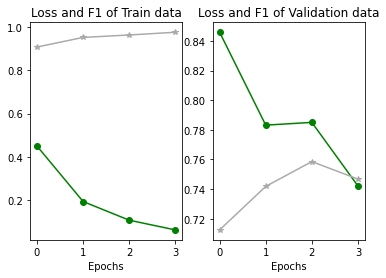

[I 2022-06-01 15:38:23,348] Trial 13 finished with value: 0.7585888776697761 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 6.079320923015268e-05, 'weight_decay': 0.00026112103114379475}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 5.522014352168289e-05, weight_decay : 0.0009716491085605633, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000503411, Avg Loss : 0.6806, f1 score : 0.8865
Epoch: 0, Step : 256, LR : 0.0000454999, Avg Loss : 0.3743, f1 score : 0.9220
Epoch 0 Total Mean Loss : 0.4688
Epoch 0 Total Mean f1 : 0.9111
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0025 Valid Acc : 0.7248 Valid f1 : 0.7352
pearson 상관 계수 ; tensor([[1.0000, 0.7633],
        [0.7633, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000365361, Avg Loss : 0.1874, f1 score : 0.9570
Epoch: 1, Step : 256, LR : 0.0000316948, Avg Loss : 0.1904, f1 score : 0.9526
Epoch 1 Total Mean Loss : 0.1863
Epoch 1 Total Mean f1 : 0.9525
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9463 Valid Acc : 0.7450 Va

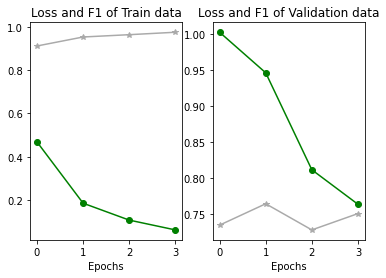

[I 2022-06-01 15:51:19,087] Trial 14 finished with value: 0.7648470876290419 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.522014352168289e-05, 'weight_decay': 0.0009716491085605633}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00013925142586683435, weight_decay : 0.0003252448250204714, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001269477, Avg Loss : 0.7197, f1 score : 0.8678
Epoch: 0, Step : 256, LR : 0.0001147394, Avg Loss : 0.4594, f1 score : 0.9077
Epoch 0 Total Mean Loss : 0.5333
Epoch 0 Total Mean f1 : 0.8984
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1620 Valid Acc : 0.7524 Valid f1 : 0.7086
pearson 상관 계수 ; tensor([[1.0000, 0.7588],
        [0.7588, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000921348, Avg Loss : 0.2681, f1 score : 0.9377
Epoch: 1, Step : 256, LR : 0.0000799265, Avg Loss : 0.2600, f1 score : 0.9353
Epoch 1 Total Mean Loss : 0.2571
Epoch 1 Total Mean f1 : 0.9377
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.0016 Valid Acc : 0.7350 V

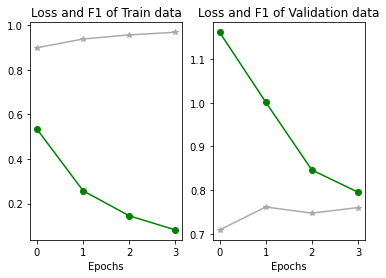

[I 2022-06-01 16:04:14,961] Trial 15 finished with value: 0.7611624863683092 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00013925142586683435, 'weight_decay': 0.0003252448250204714}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 8.926613157126946e-05, weight_decay : 0.0007370882082432991, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000853225, Avg Loss : 0.9936, f1 score : 0.8226
Epoch: 0, Step : 256, LR : 0.0000814095, Avg Loss : 0.4773, f1 score : 0.9060
Epoch: 0, Step : 384, LR : 0.0000774965, Avg Loss : 0.4370, f1 score : 0.9037
Epoch: 0, Step : 512, LR : 0.0000735834, Avg Loss : 0.4113, f1 score : 0.9186
Epoch: 0, Step : 640, LR : 0.0000696704, Avg Loss : 0.3966, f1 score : 0.9057
Epoch 0 Total Mean Loss : 0.5248
Epoch 0 Total Mean f1 : 0.8938
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.0854 Valid Acc : 0.7266 Valid f1 : 0.6512
pearson 상관 계수 ; tensor([[1.0000, 0.7222],
        [0.7222, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000630060, Avg Loss : 0.2286, f1 score : 0.9425
Epoch: 1, Step : 25

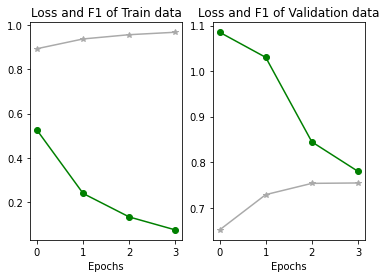

[I 2022-06-01 16:17:29,667] Trial 16 finished with value: 0.7542958958465175 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 8.926613157126946e-05, 'weight_decay': 0.0007370882082432991}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.0002647101561203629, weight_decay : 0.00016121884129144474, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002413214, Avg Loss : 1.0624, f1 score : 0.8266
Epoch: 0, Step : 256, LR : 0.0002181139, Avg Loss : 0.6609, f1 score : 0.8848
Epoch 0 Total Mean Loss : 0.7888
Epoch 0 Total Mean f1 : 0.8675
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.2589 Valid Acc : 0.7017 Valid f1 : 0.6222
pearson 상관 계수 ; tensor([[1.0000, 0.6902],
        [0.6902, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001751438, Avg Loss : 1.6498, f1 score : 0.5267
Epoch: 1, Step : 256, LR : 0.0001519364, Avg Loss : 3.1853, f1 score : 0.0000
Epoch 1 Total Mean Loss : 2.5940
Epoch 1 Total Mean f1 : 0.1862
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 2.1636 Valid Acc : 0.5825 V

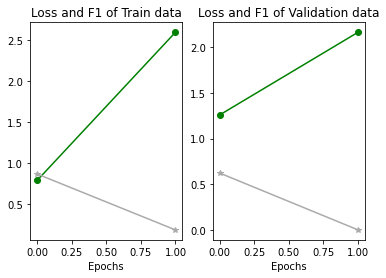

[I 2022-06-01 16:24:02,068] Trial 17 finished with value: 0.6221616914816632 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0002647101561203629, 'weight_decay': 0.00016121884129144474}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 5.5209897713173905e-05, weight_decay : 0.0003462038279442247, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000503318, Avg Loss : 0.6611, f1 score : 0.8857
Epoch: 0, Step : 256, LR : 0.0000454914, Avg Loss : 0.3614, f1 score : 0.9257
Epoch 0 Total Mean Loss : 0.4592
Epoch 0 Total Mean f1 : 0.9104
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1461 Valid Acc : 0.7156 Valid f1 : 0.7365
pearson 상관 계수 ; tensor([[1.0000, 0.7594],
        [0.7594, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000365293, Avg Loss : 0.1952, f1 score : 0.9535
Epoch: 1, Step : 256, LR : 0.0000316890, Avg Loss : 0.1865, f1 score : 0.9514
Epoch 1 Total Mean Loss : 0.1894
Epoch 1 Total Mean f1 : 0.9522
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8552 Valid Acc : 0.7597 V

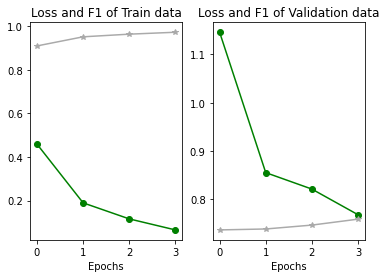

[I 2022-06-01 16:36:57,958] Trial 18 finished with value: 0.7587892470025581 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.5209897713173905e-05, 'weight_decay': 0.0003462038279442247}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 0.002574227091249425, weight_decay : 0.0009916285508871664, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0024605027, Avg Loss : 4.3397, f1 score : 0.1961
Epoch: 0, Step : 256, LR : 0.0023476598, Avg Loss : 4.4198, f1 score : 0.1790
Epoch: 0, Step : 384, LR : 0.0022348170, Avg Loss : 3.7784, f1 score : 0.1329
Epoch: 0, Step : 512, LR : 0.0021219742, Avg Loss : 4.3052, f1 score : 0.1843
Epoch: 0, Step : 640, LR : 0.0020091313, Avg Loss : 4.3488, f1 score : 0.1827
Epoch 0 Total Mean Loss : 4.3343
Epoch 0 Total Mean f1 : 0.1795
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1639 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 15.234320163726807초
green is loss, gray is f1


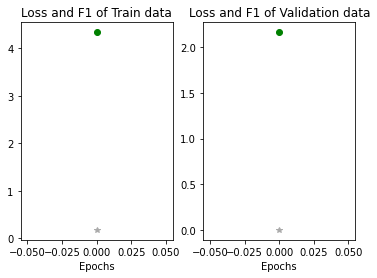

[I 2022-06-01 16:40:22,139] Trial 19 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.002574227091249425, 'weight_decay': 0.0009916285508871664}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00025303195423555865, weight_decay : 0.0005915461495396835, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002306750, Avg Loss : 0.9570, f1 score : 0.8315
Epoch: 0, Step : 256, LR : 0.0002084914, Avg Loss : 0.7318, f1 score : 0.8771
Epoch 0 Total Mean Loss : 0.7735
Epoch 0 Total Mean f1 : 0.8633
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.8914 Valid Acc : 0.6108 Valid f1 : 0.6650
pearson 상관 계수 ; tensor([[1.0000, 0.5757],
        [0.5757, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0001674170, Avg Loss : 0.4475, f1 score : 0.9086
Epoch: 1, Step : 256, LR : 0.0001452334, Avg Loss : 0.5676, f1 score : 0.8631
Epoch 1 Total Mean Loss : 0.5865
Epoch 1 Total Mean f1 : 0.8785
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 1.3105 Valid Acc : 0.6807 V

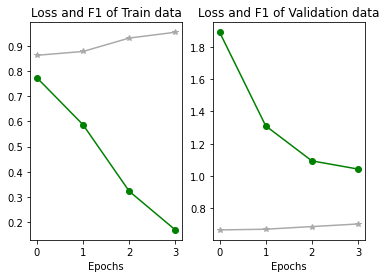

[I 2022-06-01 16:53:16,563] Trial 20 finished with value: 0.701779450385072 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00025303195423555865, 'weight_decay': 0.0005915461495396835}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 5.089321747551177e-05, weight_decay : 0.0009637307728610171, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000463965, Avg Loss : 0.6696, f1 score : 0.8888
Epoch: 0, Step : 256, LR : 0.0000419346, Avg Loss : 0.3799, f1 score : 0.9213
Epoch 0 Total Mean Loss : 0.4615
Epoch 0 Total Mean f1 : 0.9136
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9491 Valid Acc : 0.7285 Valid f1 : 0.7301
pearson 상관 계수 ; tensor([[1.0000, 0.7596],
        [0.7596, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000336732, Avg Loss : 0.1867, f1 score : 0.9501
Epoch: 1, Step : 256, LR : 0.0000292113, Avg Loss : 0.1919, f1 score : 0.9421
Epoch 1 Total Mean Loss : 0.1908
Epoch 1 Total Mean f1 : 0.9475
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8189 Valid Acc : 0.7524 Va

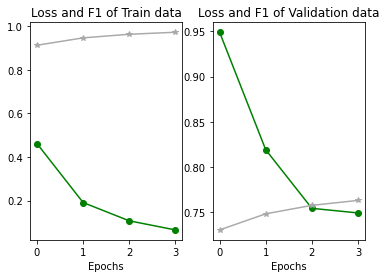

[I 2022-06-01 17:06:12,901] Trial 21 finished with value: 0.76281515144769 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.089321747551177e-05, 'weight_decay': 0.0009637307728610171}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 9.553868010611341e-05, weight_decay : 0.0007504388407201639, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000870972, Avg Loss : 0.6724, f1 score : 0.8855
Epoch: 0, Step : 256, LR : 0.0000787213, Avg Loss : 0.3990, f1 score : 0.9183
Epoch 0 Total Mean Loss : 0.4774
Epoch 0 Total Mean f1 : 0.9089
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1408 Valid Acc : 0.7350 Valid f1 : 0.6846
pearson 상관 계수 ; tensor([[1.0000, 0.7537],
        [0.7537, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000632126, Avg Loss : 0.2228, f1 score : 0.9406
Epoch: 1, Step : 256, LR : 0.0000548366, Avg Loss : 0.2190, f1 score : 0.9457
Epoch 1 Total Mean Loss : 0.2161
Epoch 1 Total Mean f1 : 0.9451
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9498 Valid Acc : 0.7468 Va

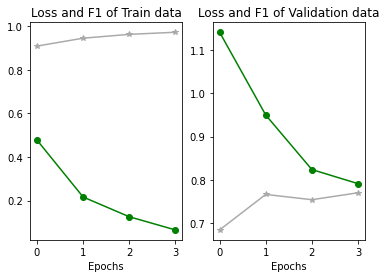

[I 2022-06-01 17:19:10,187] Trial 22 finished with value: 0.7702801328689803 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 9.553868010611341e-05, 'weight_decay': 0.0007504388407201639}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 9.102505712324972e-05, weight_decay : 0.0006641473814129855, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000829824, Avg Loss : 0.6967, f1 score : 0.8766
Epoch: 0, Step : 256, LR : 0.0000750022, Avg Loss : 0.3772, f1 score : 0.9079
Epoch 0 Total Mean Loss : 0.4909
Epoch 0 Total Mean f1 : 0.8985
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9472 Valid Acc : 0.7329 Valid f1 : 0.6858
pearson 상관 계수 ; tensor([[1.0000, 0.7734],
        [0.7734, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000602262, Avg Loss : 0.2231, f1 score : 0.9459
Epoch: 1, Step : 256, LR : 0.0000522459, Avg Loss : 0.2147, f1 score : 0.9444
Epoch 1 Total Mean Loss : 0.2181
Epoch 1 Total Mean f1 : 0.9421
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8851 Valid Acc : 0.7468 Va

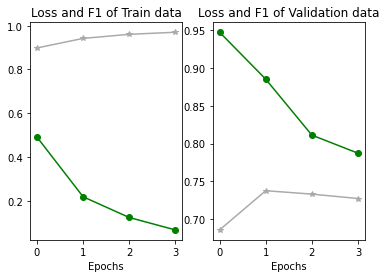

[I 2022-06-01 17:32:03,981] Trial 23 finished with value: 0.7376682373619117 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 9.102505712324972e-05, 'weight_decay': 0.0006641473814129855}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00011000480034873612, weight_decay : 0.0004939944118723644, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001002852, Avg Loss : 0.6866, f1 score : 0.8799
Epoch: 0, Step : 256, LR : 0.0000906409, Avg Loss : 0.4036, f1 score : 0.9163
Epoch 0 Total Mean Loss : 0.4952
Epoch 0 Total Mean f1 : 0.9050
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1342 Valid Acc : 0.6843 Valid f1 : 0.6925
pearson 상관 계수 ; tensor([[1.0000, 0.7278],
        [0.7278, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000727840, Avg Loss : 0.2560, f1 score : 0.9262
Epoch: 1, Step : 256, LR : 0.0000631397, Avg Loss : 0.2192, f1 score : 0.9462
Epoch 1 Total Mean Loss : 0.2302
Epoch 1 Total Mean f1 : 0.9404
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9585 Valid Acc : 0.7377 V

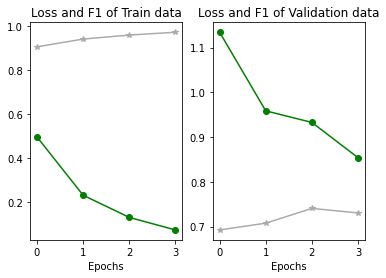

[I 2022-06-01 17:45:02,699] Trial 24 finished with value: 0.7404996055592066 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00011000480034873612, 'weight_decay': 0.0004939944118723644}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00018560611732772704, weight_decay : 0.0007903219530615529, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001692067, Avg Loss : 3.2902, f1 score : 0.0232
Epoch: 0, Step : 256, LR : 0.0001529344, Avg Loss : 3.2042, f1 score : 0.0180
Epoch 0 Total Mean Loss : 3.1998
Epoch 0 Total Mean f1 : 0.0145
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2107 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0446],
        [0.0446, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.814614057540894초
green is loss, gray is f1


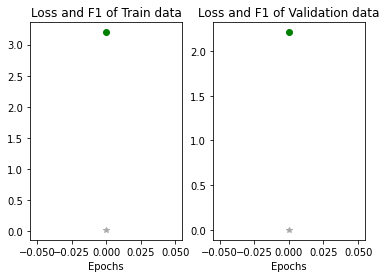

[I 2022-06-01 17:48:21,405] Trial 25 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00018560611732772704, 'weight_decay': 0.0007903219530615529}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 7.943519608642038e-05, weight_decay : 0.0003456183863359052, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000724166, Avg Loss : 0.6996, f1 score : 0.8818
Epoch: 0, Step : 256, LR : 0.0000654524, Avg Loss : 0.3896, f1 score : 0.9180
Epoch 0 Total Mean Loss : 0.4832
Epoch 0 Total Mean f1 : 0.9090
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1177 Valid Acc : 0.7082 Valid f1 : 0.7277
pearson 상관 계수 ; tensor([[1.0000, 0.7475],
        [0.7475, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000525578, Avg Loss : 0.2212, f1 score : 0.9455
Epoch: 1, Step : 256, LR : 0.0000455936, Avg Loss : 0.2153, f1 score : 0.9436
Epoch 1 Total Mean Loss : 0.2114
Epoch 1 Total Mean f1 : 0.9456
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8086 Valid Acc : 0.7616 Va

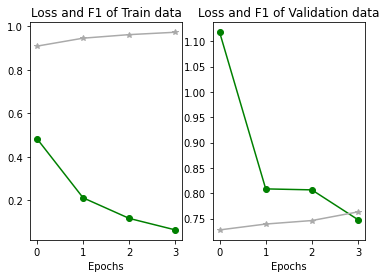

[I 2022-06-01 18:01:15,343] Trial 26 finished with value: 0.7632588511185644 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 7.943519608642038e-05, 'weight_decay': 0.0003456183863359052}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 0.00018074282579682514, weight_decay : 0.0005269025154848022, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001647731, Avg Loss : 3.2589, f1 score : 0.0275
Epoch: 0, Step : 256, LR : 0.0001489271, Avg Loss : 3.1024, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1651
Epoch 0 Total Mean f1 : 0.0097
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3191 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0370],
        [-0.0370,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.934091806411743초
green is loss, gray is f1


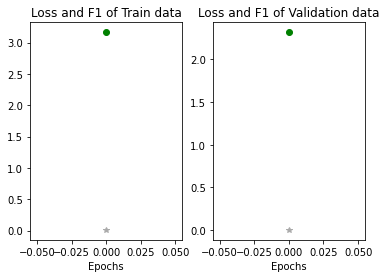

[I 2022-06-01 18:04:34,196] Trial 27 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00018074282579682514, 'weight_decay': 0.0005269025154848022}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 732
model_name : klue/bert-base, lr : 0.00033767150909201437, weight_decay : 0.0007630179759259539, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002781638, Avg Loss : 3.3102, f1 score : 0.0281
Epoch 0 Total Mean Loss : 3.2591
Epoch 0 Total Mean f1 : 0.0198
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3533 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0814],
        [-0.0814,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 3.0분 9.434352397918701초
green is loss, gray is f1


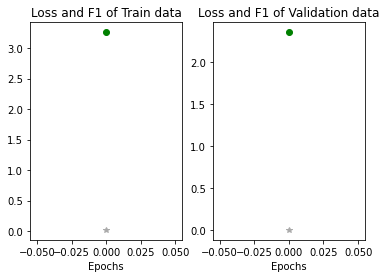

[I 2022-06-01 18:07:52,639] Trial 28 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00033767150909201437, 'weight_decay': 0.0007630179759259539}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 0.00012229629079398802, weight_decay : 0.0004068165573590092, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001168935, Avg Loss : 0.8472, f1 score : 0.8330
Epoch: 0, Step : 256, LR : 0.0001115325, Avg Loss : 0.6353, f1 score : 0.8814
Epoch: 0, Step : 384, LR : 0.0001061716, Avg Loss : 0.5705, f1 score : 0.8805
Epoch: 0, Step : 512, LR : 0.0001008107, Avg Loss : 0.4806, f1 score : 0.8998
Epoch: 0, Step : 640, LR : 0.0000954497, Avg Loss : 0.4716, f1 score : 0.9013
Epoch 0 Total Mean Loss : 0.5844
Epoch 0 Total Mean f1 : 0.8826
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.1491 Valid Acc : 0.7156 Valid f1 : 0.7267
pearson 상관 계수 ; tensor([[1.0000, 0.7292],
        [0.7292, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000863194, Avg Loss : 0.3313, f1 score : 0.9249
Epoch: 1, Step : 2

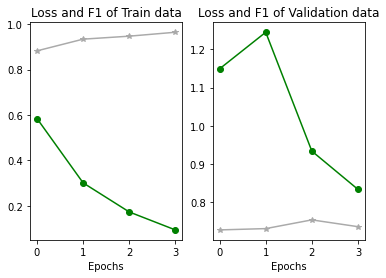

[I 2022-06-01 18:21:08,513] Trial 29 finished with value: 0.7529979921761114 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00012229629079398802, 'weight_decay': 0.0004068165573590092}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 2920
model_name : klue/bert-base, lr : 7.425546751272372e-05, weight_decay : 4.2151075307466646e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000709750, Avg Loss : 0.7752, f1 score : 0.8616
Epoch: 0, Step : 256, LR : 0.0000677200, Avg Loss : 0.4878, f1 score : 0.8968
Epoch: 0, Step : 384, LR : 0.0000644649, Avg Loss : 0.4371, f1 score : 0.9000
Epoch: 0, Step : 512, LR : 0.0000612099, Avg Loss : 0.3790, f1 score : 0.9091
Epoch: 0, Step : 640, LR : 0.0000579549, Avg Loss : 0.3495, f1 score : 0.9196
Epoch 0 Total Mean Loss : 0.4656
Epoch 0 Total Mean f1 : 0.9001
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 1.2781 Valid Acc : 0.6954 Valid f1 : 0.7280
pearson 상관 계수 ; tensor([[1.0000, 0.7198],
        [0.7198, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000524111, Avg Loss : 0.2517, f1 score : 0.9408
Epoch: 1, Step : 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Total Mean Loss : 0.2142
Epoch 1 Total Mean f1 : 0.9451
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.9260 Valid Acc : 0.7487 Valid f1 : 0.7410
pearson 상관 계수 ; tensor([[1.0000, 0.7744],
        [0.7744, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 128, LR : 0.0000338473, Avg Loss : 0.1339, f1 score : 0.9618
Epoch: 2, Step : 256, LR : 0.0000305922, Avg Loss : 0.1257, f1 score : 0.9542
Epoch: 2, Step : 384, LR : 0.0000273372, Avg Loss : 0.1145, f1 score : 0.9612
Epoch: 2, Step : 512, LR : 0.0000240822, Avg Loss : 0.1254, f1 score : 0.9480
Epoch: 2, Step : 640, LR : 0.0000208271, Avg Loss : 0.1124, f1 score : 0.9659
Epoch 2 Total Mean Loss : 0.1220
Epoch 2 Total Mean f1 : 0.9584
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****
Epoch 2 Valid Loss : 0.8040 Valid Acc : 0.7773 Valid f1 : 0.7480
pearson 상관 계수 ; tensor([[1.0000, 0.8036],
        [0.8036, 1.0000]], device='cud

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Total Mean Loss : 0.0643
Epoch 3 Total Mean f1 : 0.9697
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****
Epoch 3 Valid Loss : 0.7954 Valid Acc : 0.7865 Valid f1 : 0.7633
pearson 상관 계수 ; tensor([[1.0000, 0.7998],
        [0.7998, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 13.0분 4.325696229934692초
green is loss, gray is f1


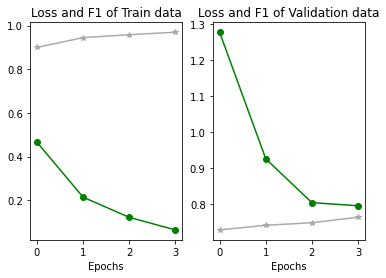

[I 2022-06-01 18:34:21,714] Trial 30 finished with value: 0.7632899804656912 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 7.425546751272372e-05, 'weight_decay': 4.2151075307466646e-05}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 4 epochs: 1460
model_name : klue/bert-base, lr : 6.344250920396248e-05, weight_decay : 0.0008725976913713922, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000578370, Avg Loss : 0.7172, f1 score : 0.8821
Epoch: 0, Step : 256, LR : 0.0000522749, Avg Loss : 0.3620, f1 score : 0.9237
Epoch 0 Total Mean Loss : 0.4789
Epoch 0 Total Mean f1 : 0.9085
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.9802 Valid Acc : 0.7174 Valid f1 : 0.7116
pearson 상관 계수 ; tensor([[1.0000, 0.7590],
        [0.7590, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000419763, Avg Loss : 0.2053, f1 score : 0.9499
Epoch: 1, Step : 256, LR : 0.0000364143, Avg Loss : 0.2018, f1 score : 0.9476
Epoch 1 Total Mean Loss : 0.1999
Epoch 1 Total Mean f1 : 0.9485
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.8505 Valid Acc : 0.7524 Va

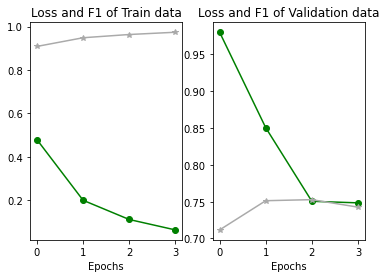

[I 2022-06-01 18:47:18,236] Trial 31 finished with value: 0.752729056783946 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 6.344250920396248e-05, 'weight_decay': 0.0008725976913713922}. Best is trial 12 with value: 0.7790662176274209.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [37]:
print('klue/bert-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

In [38]:
print(f'study.best_trial.value : {study.best_trial.value}') 
print(f'study.best_params : {study.best_params}') 
print(f'study.trials : {study.trials}')
optuna.visualization.plot_edf(study)

study.best_trial.value : 0.7790662176274209
study.best_params : {'per_device_train_batch_size': 32, 'learning_rate': 5.062561933423002e-05, 'weight_decay': 0.0008860446475103689}
study.trials : [FrozenTrial(number=0, values=[0.0], datetime_start=datetime.datetime(2022, 6, 1, 13, 47, 40, 72300), datetime_complete=datetime.datetime(2022, 6, 1, 13, 50, 58, 452399), params={'per_device_train_batch_size': 16, 'learning_rate': 0.0002413759008436688, 'weight_decay': 7.518785496613016e-05}, distributions={'per_device_train_batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'learning_rate': LogUniformDistribution(high=0.005, low=5e-05), 'weight_decay': LogUniformDistribution(high=0.001, low=4e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None), FrozenTrial(number=1, values=[0.0], datetime_start=datetime.datetime(2022, 6, 1, 13, 50, 58, 455492), datetime_complete=datetime.datetime(2022, 6, 1, 13, 54, 21, 55913), params={'per_

### 'monologg/kobert'  -> 0에 수렴

[I 2022-06-01 21:14:59,636] A new study created in memory with name: hyper-parameter-search


monologg/kobert




Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

batch_size : 32
batch_size : 32


Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.00021927254650446886, weight_decay : 8.995326355883898e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001998985, Avg Loss : 3.1296, f1 score : 0.0125
Epoch: 0, Step : 256, LR : 0.0001806746, Avg Loss : 3.1716, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1381
Epoch 0 Total Mean f1 : 0.0044
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2350 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 29.827378749847412초
green is loss, gray is f1


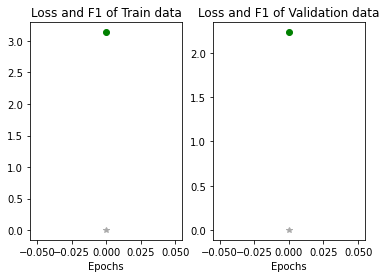

[I 2022-06-01 21:15:45,828] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00021927254650446886, 'weight_decay': 8.995326355883898e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.00032146487293577763, weight_decay : 0.0005569377103707173, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0003072632, Avg Loss : 3.4381, f1 score : 0.0260
Epoch: 0, Step : 256, LR : 0.0002931716, Avg Loss : 3.2387, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002790799, Avg Loss : 3.0491, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0002649883, Avg Loss : 3.1057, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0002508967, Avg Loss : 3.1558, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1990
Epoch 0 Total Mean f1 : 0.0046
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2169 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 58.01336884498596초
green is loss, gray is f1


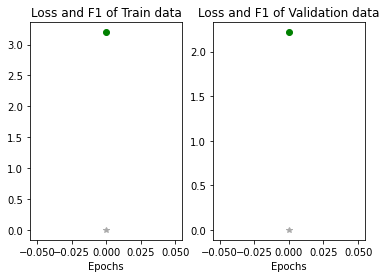

[I 2022-06-01 21:16:53,057] Trial 1 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00032146487293577763, 'weight_decay': 0.0005569377103707173}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.002534973064582501, weight_decay : 6.27561991744002e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0023109926, Avg Loss : 3.9999, f1 score : 0.1604
Epoch: 0, Step : 256, LR : 0.0020887484, Avg Loss : 3.4962, f1 score : 0.0608
Epoch 0 Total Mean Loss : 3.6495
Epoch 0 Total Mean f1 : 0.1009
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3590 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 29.90152096748352초
green is loss, gray is f1


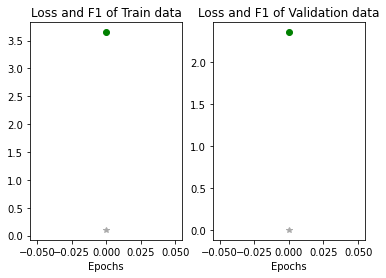

[I 2022-06-01 21:17:32,170] Trial 2 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.002534973064582501, 'weight_decay': 6.27561991744002e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 732
model_name : monologg/kobert, lr : 0.00013260665632128748, weight_decay : 0.00022454367853009966, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001092375, Avg Loss : 3.1452, f1 score : 0.0121
Epoch 0 Total Mean Loss : 3.1163
Epoch 0 Total Mean f1 : 0.0085
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4288 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 18.111561059951782초
green is loss, gray is f1


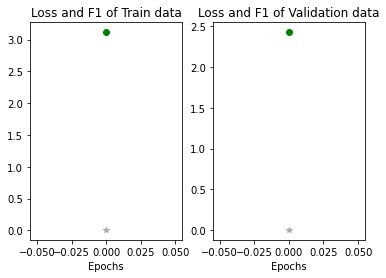

[I 2022-06-01 21:17:59,451] Trial 3 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00013260665632128748, 'weight_decay': 0.00022454367853009966}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 732
model_name : monologg/kobert, lr : 0.0003800964834008893, weight_decay : 6.185370459605052e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0003131123, Avg Loss : 3.1960, f1 score : 0.0138
Epoch 0 Total Mean Loss : 3.1632
Epoch 0 Total Mean f1 : 0.0097
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1991 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 18.160030126571655초
green is loss, gray is f1


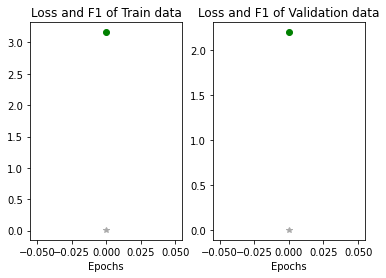

[I 2022-06-01 21:18:26,757] Trial 4 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0003800964834008893, 'weight_decay': 6.185370459605052e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 732
model_name : monologg/kobert, lr : 0.002335573127848907, weight_decay : 4.122122877564014e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0019239762, Avg Loss : 3.6944, f1 score : 0.0779
Epoch 0 Total Mean Loss : 3.5361
Epoch 0 Total Mean f1 : 0.0549
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2908 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 18.156614542007446초
green is loss, gray is f1


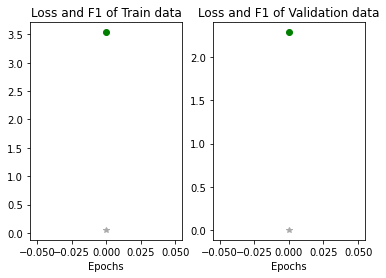

[I 2022-06-01 21:18:54,137] Trial 5 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.002335573127848907, 'weight_decay': 4.122122877564014e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 732
model_name : monologg/kobert, lr : 0.00018588758060401154, weight_decay : 7.554698275969018e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001531287, Avg Loss : 3.1333, f1 score : 0.0078
Epoch 0 Total Mean Loss : 3.1255
Epoch 0 Total Mean f1 : 0.0055
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3595 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 18.14981174468994초
green is loss, gray is f1


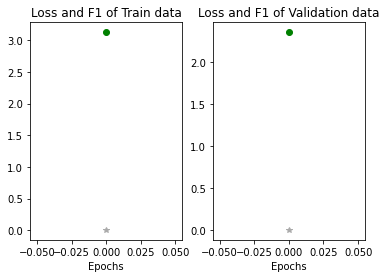

[I 2022-06-01 21:19:21,405] Trial 6 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.00018588758060401154, 'weight_decay': 7.554698275969018e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.000327413295194115, weight_decay : 0.00012778355754744438, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002984843, Avg Loss : 3.1800, f1 score : 0.0117
Epoch: 0, Step : 256, LR : 0.0002697796, Avg Loss : 3.1151, f1 score : 0.0035
Epoch 0 Total Mean Loss : 3.1446
Epoch 0 Total Mean f1 : 0.0053
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1635 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 29.980125904083252초
green is loss, gray is f1


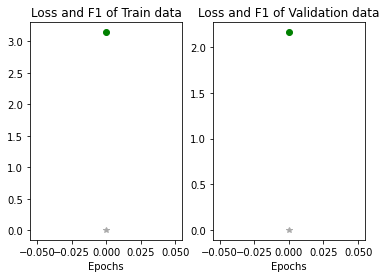

[I 2022-06-01 21:20:00,516] Trial 7 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.000327413295194115, 'weight_decay': 0.00012778355754744438}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.004091978156767142, weight_decay : 0.00028231691989864853, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0039112024, Avg Loss : 4.5719, f1 score : 0.1881
Epoch: 0, Step : 256, LR : 0.0037318280, Avg Loss : 3.9367, f1 score : 0.1787
Epoch: 0, Step : 384, LR : 0.0035524536, Avg Loss : 3.5875, f1 score : 0.1174
Epoch: 0, Step : 512, LR : 0.0033730793, Avg Loss : 3.6571, f1 score : 0.1406
Epoch: 0, Step : 640, LR : 0.0031937049, Avg Loss : 3.4742, f1 score : 0.0649
Epoch 0 Total Mean Loss : 3.7823
Epoch 0 Total Mean f1 : 0.1263
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1949 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 58.20806384086609초
green is loss, gray is f1


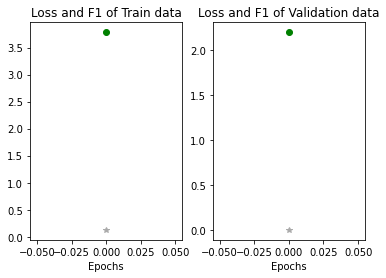

[I 2022-06-01 21:21:07,886] Trial 8 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.004091978156767142, 'weight_decay': 0.00028231691989864853}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 732
model_name : monologg/kobert, lr : 0.0025388085066791947, weight_decay : 0.00011582250375005915, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0020913955, Avg Loss : 3.6091, f1 score : 0.0445
Epoch 0 Total Mean Loss : 3.5118
Epoch 0 Total Mean f1 : 0.0574
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.9293 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 18.32123589515686초
green is loss, gray is f1


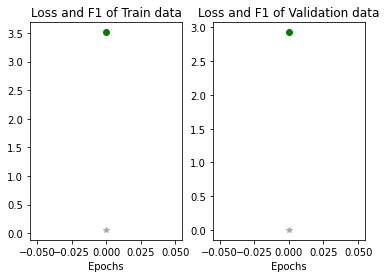

[I 2022-06-01 21:21:35,367] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.0025388085066791947, 'weight_decay': 0.00011582250375005915}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 6.669456957520866e-05, weight_decay : 0.0008383663840316053, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000608017, Avg Loss : 3.1648, f1 score : 0.0009
Epoch: 0, Step : 256, LR : 0.0000549545, Avg Loss : 3.0450, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1062
Epoch 0 Total Mean f1 : 0.0003
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2524 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.015724897384644초
green is loss, gray is f1


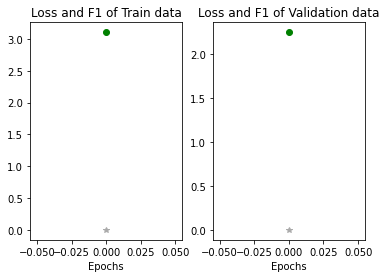

[I 2022-06-01 21:22:14,605] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 6.669456957520866e-05, 'weight_decay': 0.0008383663840316053}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.0008644010012814752, weight_decay : 0.0005589093704705049, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0008262134, Avg Loss : 3.3224, f1 score : 0.0705
Epoch: 0, Step : 256, LR : 0.0007883219, Avg Loss : 3.2432, f1 score : 0.0474
Epoch: 0, Step : 384, LR : 0.0007504303, Avg Loss : 3.2446, f1 score : 0.0190
Epoch: 0, Step : 512, LR : 0.0007125388, Avg Loss : 3.2844, f1 score : 0.0504
Epoch: 0, Step : 640, LR : 0.0006746472, Avg Loss : 3.1715, f1 score : 0.0051
Epoch 0 Total Mean Loss : 3.2423
Epoch 0 Total Mean f1 : 0.0338
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2250 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 58.37203669548035초
green is loss, gray is f1


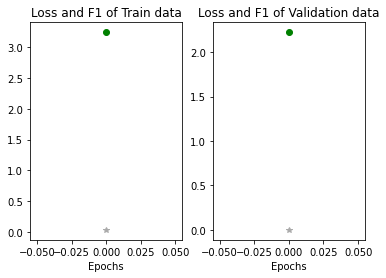

[I 2022-06-01 21:23:22,100] Trial 11 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0008644010012814752, 'weight_decay': 0.0005589093704705049}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.000765984100558225, weight_decay : 0.00039631535716212865, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0007321444, Avg Loss : 3.3108, f1 score : 0.0434
Epoch: 0, Step : 256, LR : 0.0006985670, Avg Loss : 3.2928, f1 score : 0.0374
Epoch: 0, Step : 384, LR : 0.0006649896, Avg Loss : 3.1816, f1 score : 0.0135
Epoch: 0, Step : 512, LR : 0.0006314122, Avg Loss : 3.2287, f1 score : 0.0035
Epoch: 0, Step : 640, LR : 0.0005978349, Avg Loss : 3.2123, f1 score : 0.0048
Epoch 0 Total Mean Loss : 3.2255
Epoch 0 Total Mean f1 : 0.0204
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.5950 Valid Acc : 0.3973 Valid f1 : 0.5857
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0005406484, Avg Loss : 3.2279, f1 score : 0.0469
Epoch: 1, Step : 256, LR : 0.00

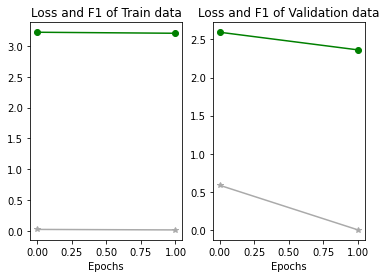

[I 2022-06-01 21:25:27,817] Trial 12 finished with value: 0.585747622409982 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.000765984100558225, 'weight_decay': 0.00039631535716212865}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.000968639630502594, weight_decay : 0.0003008232302816292, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0008830543, Avg Loss : 3.3342, f1 score : 0.0363
Epoch: 0, Step : 256, LR : 0.0007981325, Avg Loss : 3.1401, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.2156
Epoch 0 Total Mean f1 : 0.0157
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1657 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.470792770385742초
green is loss, gray is f1


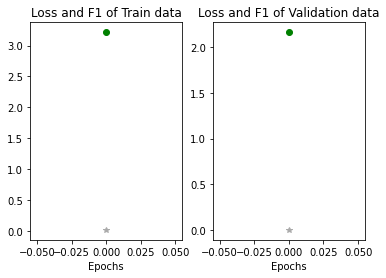

[I 2022-06-01 21:26:07,532] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.000968639630502594, 'weight_decay': 0.0003008232302816292}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.0008013782120308446, weight_decay : 0.00014727697316153798, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0007659749, Avg Loss : 3.2410, f1 score : 0.0457
Epoch: 0, Step : 256, LR : 0.0007308460, Avg Loss : 3.2820, f1 score : 0.0242
Epoch: 0, Step : 384, LR : 0.0006957170, Avg Loss : 3.2929, f1 score : 0.0167
Epoch: 0, Step : 512, LR : 0.0006605881, Avg Loss : 3.2429, f1 score : 0.0325
Epoch: 0, Step : 640, LR : 0.0006254592, Avg Loss : 3.1383, f1 score : 0.0235
Epoch 0 Total Mean Loss : 3.2285
Epoch 0 Total Mean f1 : 0.0251
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1864 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 59.658653020858765초
green is loss, gray is f1


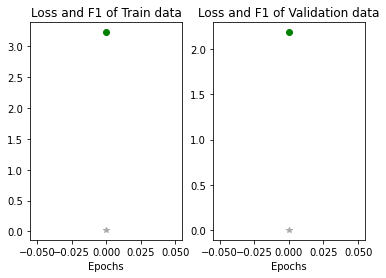

[I 2022-06-01 21:27:16,401] Trial 14 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0008013782120308446, 'weight_decay': 0.00014727697316153798}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.00015056730108698962, weight_decay : 0.0004323478908868143, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0001439155, Avg Loss : 3.1870, f1 score : 0.0179
Epoch: 0, Step : 256, LR : 0.0001373153, Avg Loss : 3.1365, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0001307151, Avg Loss : 3.1817, f1 score : 0.0017
Epoch: 0, Step : 512, LR : 0.0001241149, Avg Loss : 3.1121, f1 score : 0.0016
Epoch: 0, Step : 640, LR : 0.0001175147, Avg Loss : 3.0607, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1468
Epoch 0 Total Mean f1 : 0.0037
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1645 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 58.88424897193909초
green is loss, gray is f1


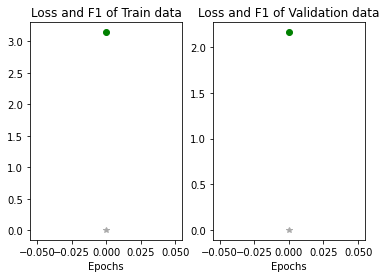

[I 2022-06-01 21:28:24,461] Trial 15 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.00015056730108698962, 'weight_decay': 0.0004323478908868143}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 5.22068934559979e-05, weight_decay : 0.00017659665905422, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000475941, Avg Loss : 3.1177, f1 score : 0.0032
Epoch: 0, Step : 256, LR : 0.0000430170, Avg Loss : 3.1024, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1000
Epoch 0 Total Mean f1 : 0.0011
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2144 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.137157201766968초
green is loss, gray is f1


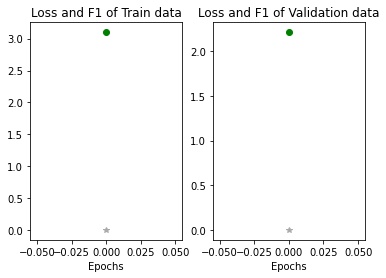

[I 2022-06-01 21:29:03,836] Trial 16 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5.22068934559979e-05, 'weight_decay': 0.00017659665905422}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.0004981093706355494, weight_decay : 8.809101546112294e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0004761039, Avg Loss : 3.3211, f1 score : 0.0253
Epoch: 0, Step : 256, LR : 0.0004542689, Avg Loss : 3.2264, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0004324340, Avg Loss : 3.1939, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0004105991, Avg Loss : 3.1928, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0003887641, Avg Loss : 3.1823, f1 score : 0.0180
Epoch 0 Total Mean Loss : 3.2063
Epoch 0 Total Mean f1 : 0.0076
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1647 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 59.73098683357239초
green is loss, gray is f1


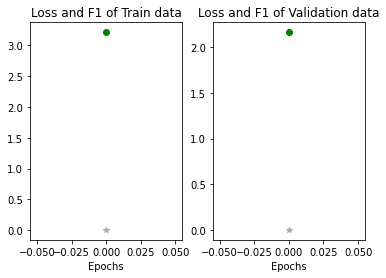

[I 2022-06-01 21:30:12,750] Trial 17 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0004981093706355494, 'weight_decay': 8.809101546112294e-05}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0014247392385893516, weight_decay : 0.0003529461128184841, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0012988547, Avg Loss : 3.5723, f1 score : 0.0866
Epoch: 0, Step : 256, LR : 0.0011739461, Avg Loss : 3.2637, f1 score : 0.0494
Epoch 0 Total Mean Loss : 3.3743
Epoch 0 Total Mean f1 : 0.0608
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1935 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.200705528259277초
green is loss, gray is f1


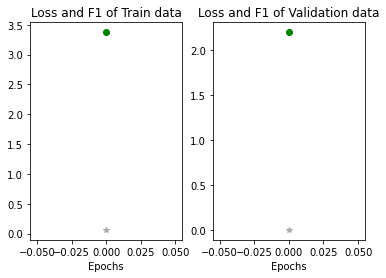

[I 2022-06-01 21:30:52,174] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0014247392385893516, 'weight_decay': 0.0003529461128184841}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.00022404637382196632, weight_decay : 4.242702087335324e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002042505, Avg Loss : 3.2286, f1 score : 0.0309
Epoch: 0, Step : 256, LR : 0.0001846081, Avg Loss : 3.1086, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1380
Epoch 0 Total Mean f1 : 0.0109
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2165 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.135953903198242초
green is loss, gray is f1


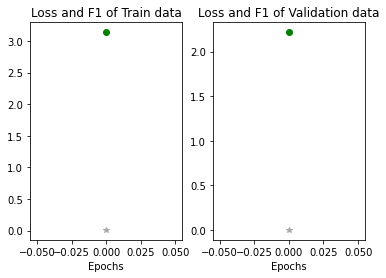

[I 2022-06-01 21:31:31,491] Trial 19 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00022404637382196632, 'weight_decay': 4.242702087335324e-05}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 9.883607480361038e-05, weight_decay : 0.0009713131647253706, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000944697, Avg Loss : 3.1476, f1 score : 0.0281
Epoch: 0, Step : 256, LR : 0.0000901371, Avg Loss : 3.1611, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000858046, Avg Loss : 3.1077, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000814721, Avg Loss : 3.0923, f1 score : 0.0017
Epoch: 0, Step : 640, LR : 0.0000771395, Avg Loss : 3.1743, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1318
Epoch 0 Total Mean f1 : 0.0053
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2991 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 0.14748692512512207초
green is loss, gray is f1


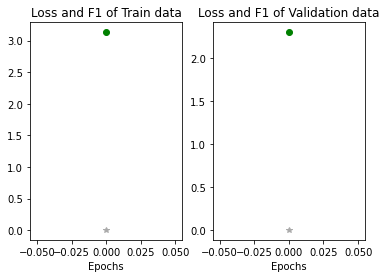

[I 2022-06-01 21:32:40,832] Trial 20 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 9.883607480361038e-05, 'weight_decay': 0.0009713131647253706}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0012813955711694542, weight_decay : 0.00037040435744688975, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0011681764, Avg Loss : 3.5999, f1 score : 0.0789
Epoch: 0, Step : 256, LR : 0.0010558348, Avg Loss : 3.4913, f1 score : 0.1143
Epoch 0 Total Mean Loss : 3.4411
Epoch 0 Total Mean f1 : 0.0781
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.8130 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.185680627822876초
green is loss, gray is f1


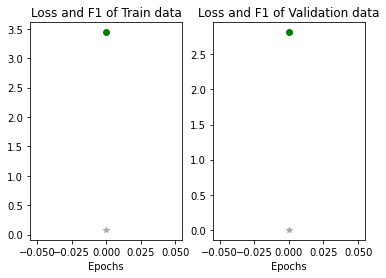

[I 2022-06-01 21:33:20,253] Trial 21 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0012813955711694542, 'weight_decay': 0.00037040435744688975}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.00023204054340419548, weight_decay : 4.329469936636055e-05, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002115383, Avg Loss : 3.2152, f1 score : 0.0225
Epoch: 0, Step : 256, LR : 0.0001911951, Avg Loss : 3.1415, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1553
Epoch 0 Total Mean f1 : 0.0079
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3316 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.48896288871765초
green is loss, gray is f1


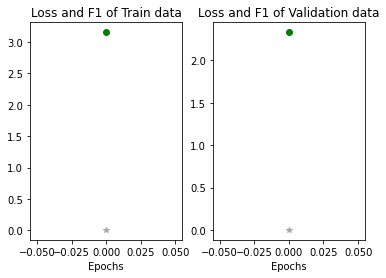

[I 2022-06-01 21:33:59,902] Trial 22 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00023204054340419548, 'weight_decay': 4.329469936636055e-05}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 7.985773038175938e-05, weight_decay : 0.0007857932582046362, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000763298, Avg Loss : 3.1786, f1 score : 0.0116
Epoch: 0, Step : 256, LR : 0.0000728292, Avg Loss : 3.1378, f1 score : 0.0135
Epoch: 0, Step : 384, LR : 0.0000693285, Avg Loss : 3.1824, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000658279, Avg Loss : 3.1721, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000623273, Avg Loss : 3.1250, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1592
Epoch 0 Total Mean f1 : 0.0044
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1975 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 0.2687380313873291초
green is loss, gray is f1


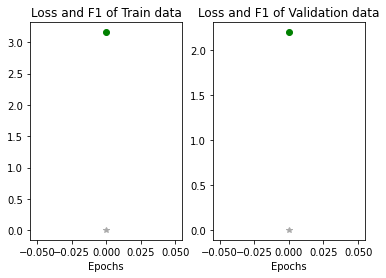

[I 2022-06-01 21:35:09,372] Trial 23 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 7.985773038175938e-05, 'weight_decay': 0.0007857932582046362}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.001310186693742652, weight_decay : 0.00020283659492629182, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0011944236, Avg Loss : 3.5605, f1 score : 0.0428
Epoch: 0, Step : 256, LR : 0.0010795579, Avg Loss : 3.1689, f1 score : 0.0053
Epoch 0 Total Mean Loss : 3.2990
Epoch 0 Total Mean f1 : 0.0241
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.3338 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 31.617729902267456초
green is loss, gray is f1


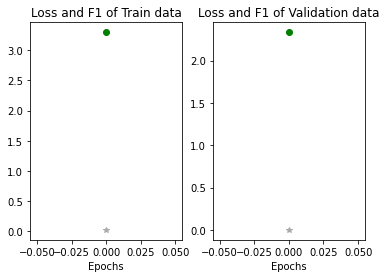

[I 2022-06-01 21:35:50,252] Trial 24 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001310186693742652, 'weight_decay': 0.00020283659492629182}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0006012404624562845, weight_decay : 0.0004471977452705091, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005481172, Avg Loss : 3.3921, f1 score : 0.0483
Epoch: 0, Step : 256, LR : 0.0004954057, Avg Loss : 3.1648, f1 score : 0.0145
Epoch 0 Total Mean Loss : 3.2279
Epoch 0 Total Mean f1 : 0.0221
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4851 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.531431198120117초
green is loss, gray is f1


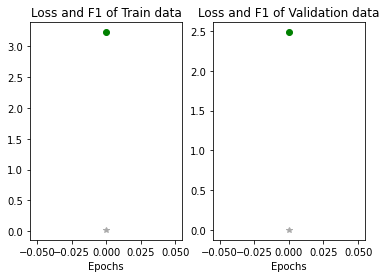

[I 2022-06-01 21:36:30,057] Trial 25 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0006012404624562845, 'weight_decay': 0.0004471977452705091}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 9.827451515547629e-05, weight_decay : 0.0007115046680853467, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000939329, Avg Loss : 3.2528, f1 score : 0.0290
Epoch: 0, Step : 256, LR : 0.0000896250, Avg Loss : 3.1688, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000853171, Avg Loss : 3.0981, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000810092, Avg Loss : 3.1480, f1 score : 0.0085
Epoch: 0, Step : 640, LR : 0.0000767012, Avg Loss : 3.0234, f1 score : 0.0017
Epoch 0 Total Mean Loss : 3.1429
Epoch 0 Total Mean f1 : 0.0080
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1844 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 1.0분 0.15610194206237793초
green is loss, gray is f1


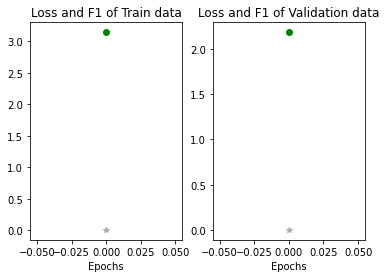

[I 2022-06-01 21:37:39,440] Trial 26 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 9.827451515547629e-05, 'weight_decay': 0.0007115046680853467}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0013508914790257272, weight_decay : 0.00021773365183975815, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0012315319, Avg Loss : 3.4949, f1 score : 0.0791
Epoch: 0, Step : 256, LR : 0.0011130976, Avg Loss : 3.1917, f1 score : 0.0316
Epoch 0 Total Mean Loss : 3.2826
Epoch 0 Total Mean f1 : 0.0393
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.2616 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.540971994400024초
green is loss, gray is f1


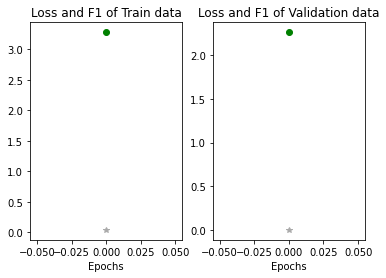

[I 2022-06-01 21:38:19,153] Trial 27 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0013508914790257272, 'weight_decay': 0.00021773365183975815}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0005951614371459039, weight_decay : 0.0005069907818377592, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005425753, Avg Loss : 3.2808, f1 score : 0.0262
Epoch: 0, Step : 256, LR : 0.0004903967, Avg Loss : 3.1550, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.2248
Epoch 0 Total Mean f1 : 0.0187
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4406 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.668816804885864초
green is loss, gray is f1


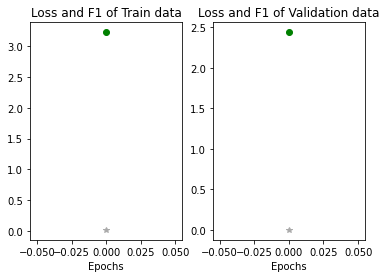

[I 2022-06-01 21:38:59,058] Trial 28 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0005951614371459039, 'weight_decay': 0.0005069907818377592}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 2920
model_name : monologg/kobert, lr : 0.0002606959803012454, weight_decay : 0.0006440417800086754, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0002491789, Avg Loss : 3.1982, f1 score : 0.0235
Epoch: 0, Step : 256, LR : 0.0002377512, Avg Loss : 3.2427, f1 score : 0.0106
Epoch: 0, Step : 384, LR : 0.0002263234, Avg Loss : 3.0922, f1 score : 0.0043
Epoch: 0, Step : 512, LR : 0.0002148956, Avg Loss : 3.1771, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0002034679, Avg Loss : 3.1200, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1640
Epoch 0 Total Mean f1 : 0.0068
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1790 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 58.90507388114929초
green is loss, gray is f1


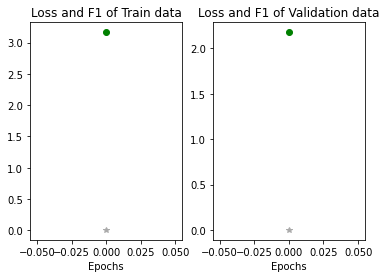

[I 2022-06-01 21:40:07,158] Trial 29 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0002606959803012454, 'weight_decay': 0.0006440417800086754}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.00043564178763017133, weight_decay : 0.00024377103210116623, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0003971502, Avg Loss : 3.2125, f1 score : 0.0377
Epoch: 0, Step : 256, LR : 0.0003589569, Avg Loss : 3.1465, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1754
Epoch 0 Total Mean f1 : 0.0182
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.4704 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.13681721687317초
green is loss, gray is f1


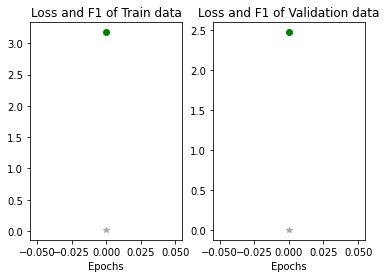

[I 2022-06-01 21:40:46,642] Trial 30 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.00043564178763017133, 'weight_decay': 0.00024377103210116623}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 4 epochs: 1460
model_name : monologg/kobert, lr : 0.0006406138247022354, weight_decay : 0.00045602025801209125, epochs : 4
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0005840116, Avg Loss : 3.2911, f1 score : 0.0290
Epoch: 0, Step : 256, LR : 0.0005278482, Avg Loss : 3.2160, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.2067
Epoch 0 Total Mean f1 : 0.0102
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 2.1633 Valid Acc : 0.5825 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Train Finished
time : 0.0분 30.125646591186523초
green is loss, gray is f1


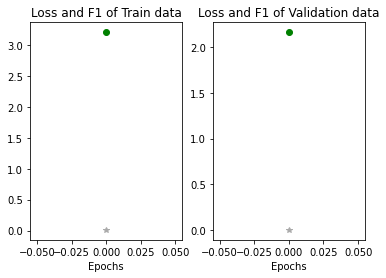

[I 2022-06-01 21:41:26,033] Trial 31 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0006406138247022354, 'weight_decay': 0.00045602025801209125}. Best is trial 12 with value: 0.585747622409982.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [44]:
print('monologg/kobert\n\n')
study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=32)

# Test : 최적화된 모델로 KLUE-sts Validation 문장 test

In [22]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/nlp/kr-bert_loss:0.6860_f1:0.7798.ckpt')
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss', 'f1'])

In [54]:
def test(model, test_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, total_pearson= 0,0, 0, 0
    prediction = {'probs' : [], 'batch_input_ids' : []}   # batch_input_ids는 문장 확인을 위해 넣어둠.

    for step, batch in enumerate(test_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch

        prediction['batch_input_ids'].extend(batch_input['input_ids'])
        
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
        
        prediction['probs'].extend(probs)

        # loss
        loss = loss_fct(probs, batch_label)
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(probs, batch_label) :
          if (p > 3 and b > 3) or (p < 3 and b < 3 ) :
            acc += 1
        
        acc = acc / len(probs)
        total_acc+=acc
        
        # pearsonr 상관계수
        pearson = torch.corrcoef(torch.stack([probs, batch_label], dim=0))
        total_pearson += pearson

        # f1-score
        f1 = f1_score([0 if p < 3 else 1 for p in batch_label], [0 if p < 3 else 1 for p in probs])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    total_pearson = total_pearson/(step+1)
    return prediction, total_loss, total_acc, total_f1, total_pearson

In [55]:
valid_dataset = CustomDataset(dataset['validation'])
validation_loader = make_dataloader(valid_dataset, 'snunlp/KR-Medium', 32, 'valid')

model = CustomSTS(hidden_size=768, model_name='snunlp/KR-Medium')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
prediction, total_loss, total_acc, total_f1, total_pearson = test(model, validation_loader)

batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
import pandas as pd
df = pd.DataFrame({'sentence1' : [data['sentence1'] for data in dataset['validation']],
                   'sentence2' : [data['sentence2'] for data in dataset['validation']],
                   'real-label' : [data['labels']['real-label'] for data in dataset['validation']]
                   })
df.head()

,sentence1,sentence2,real-label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.714286
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.500000


In [60]:
tokenizer.decode(prediction['batch_input_ids'][0], skip_special_tokens=True)

'무엇보다도호스트분들이너무친절하셨습니다 무엇보다도호스트들은매우친절했습니다'

In [61]:
prediction['probs'] = [p.item() for p in prediction['probs']]
df['probs'] = prediction['probs']
df['distance'] = df['real-label'] - df['probs']
df.head()

,sentence1,sentence2,real-label,probs,distance
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143,4.693001,0.164142
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571,1.891190,-0.462619
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714,1.660383,-0.374669
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.714286,3.512707,0.201579
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.500000,2.331393,0.168607


In [62]:
df.to_csv('klue-dataset-validation-prediction.csv')

In [63]:
df[df['distance'] > 1.5].index

Int64Index([22, 98, 108, 120, 140, 149, 178, 223, 268, 383, 435, 446], dtype='int64')

In [65]:
df.iloc[[22, 98, 108, 120, 140, 149, 178, 223, 268, 383, 435, 446]]

,sentence1,sentence2,real-label,probs,distance
22,깨끗하고 와이파이랑 넷플릭스도 됩니다!,깨끗하고 Wi-Fi와 Netflix를 사용할 수 있습니다!,4.714286,2.717394,1.996891
98,어머니 생일이 언제셔?,어머님이 태어나신 날짜가 어떻게 되나요?,3.833333,1.663069,2.170265
108,타이 쿠킹클래스가 처음인 분들께 추천합니다,태국 요리 교실에 처음 오신 분들께 추천합니다.,4.571429,2.858377,1.713051
120,이태리에서 손에 꼽힐 정도로 좋았습니다.,그것은 이탈리아에서 최고 중의 하나였습니다.,3.833333,1.125535,2.707799
140,"먼저, 1부에서는 코로나19 지원대책으로 두 개의 안건을 논의했다.","먼저, 첫 번째 파트에서는 Corona 19 지원 조치로서 두 가지 문제에 대해 논...",4.333333,2.482380,1.850953
149,저번 년도 용평엔 얼마나 많은 눈이 왔나요?,용평 지역은 강설량이 어느정도입니까? 작년 기준으로.,4.600000,3.003708,1.596292
178,어머니께선 몇 년 몇 월 며칠에 태어나셨는지요?,어머님 생신이 언제세요?,3.333333,0.736243,2.597091
223,약속을 때가 되서 알리지 마시고 미리 확인해주세요.,마음대로 늦게 오지 말고 늦을 때에는 사전에 사유를 연락해주시지요.,1.857143,0.280036,1.577107
268,침대가 살짝 작은 느낌이 있는데 180센치 이상의 키나 100키로 이상의 무게가 아...,"침대는 약간 작게 느껴지지만, 180cm 이상 혹은 100kg 이상 크지 않으면 불...",4.166667,2.501809,1.664857
383,이탈리아에서 묵었던 숙소 화장실 중 제일 컸어요.,그것은 내가 이탈리아에서 머물렀던 가장 큰 욕실입니다.,3.600000,1.546705,2.053295


In [68]:
tokenizer('깨끗하고 Wi-Fi와 Netflix를 사용할 수 있습니다!	')

{'input_ids': [2, 10269, 8455, 59, 5250, 17, 42, 5250, 5284, 50, 13969, 5253, 5423, 5250, 5753, 5029, 17572, 3320, 9594, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [70]:
tokenizer.decode([2, 10269, 8455, 59, 5250, 17, 42, 5250, 5284, 50, 13969, 5253, 5423, 5250, 5753, 5029, 17572, 3320, 9594, 5, 3])

'[CLS] 깨끗하고 Wi - Fi와 Netflix를 사용할 수 있습니다! [SEP]'

# 전처리를 안한다면? ( 하이퍼파라미터는 그대로 )

batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 20 epochs: 3660
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 5e-05, epochs : 20
*****Epoch 0 Train Start*****
Epoch: 0, Step : 128, LR : 0.0000964754, Avg Loss : 0.6384, f1 score : 0.8933
Epoch 0 Total Mean Loss : 0.5271
Epoch 0 Total Mean f1 : 0.9067
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8552 Valid Acc : 0.7164 Valid f1 : 0.7181
pearson 상관 계수 ; tensor([[1.0000, 0.7997],
        [0.7997, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 128, LR : 0.0000914754, Avg Loss : 0.1818, f1 score : 0.9551
Epoch 1 Total Mean Loss : 0.1770
Epoch 1 Total Mean f1 : 0.9551
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.6164 Valid Acc : 0.7660 Valid f1 : 0.7293
pearson 상관 계수 ; tensor([[1.0000, 0.8465],
        [0.8465, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 12

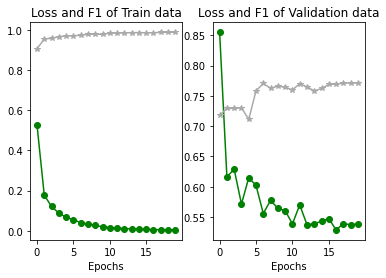

<Figure size 432x288 with 0 Axes>

In [74]:
# 64, 32, 1e-04, 5e-05, 4 
train_batch_size = 64
model_name = 'snunlp/KR-Medium'

train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')

learning_rate = 1e-04
weight_decay = 5e-05

model, optimizer, scheduler = initializer(train_dataloader, 20, model_name, learning_rate, weight_decay)

start = time.time()
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 20, model_name)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

draw_plot(train_dict, valid_dict, 0)